# **Лабораторная работа 1: Влияние параметра *eps* для сетей FC, LeNet на датасете MNIST, а также для сетей NiN, LeNEt на датасете CIFAR**

Выполнил(а) студент **2** курса группы: **ББМО-02-23**

ФИО: **Кузина Анастасия Сергеевна**

##**1. Копируем проект по ссылке в локальную среду выполнения Google Colab [(Ссылка на GitHub)](https://github.com/ewatson2/EEL6812_DeepFool_Project)**

In [2]:
! git clone https://github.com/ewatson2/EEL6812_DeepFool_Project

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93 (from 1)
Receiving objects: 100% (96/96), 33.99 MiB | 12.77 MiB/s, done.
Resolving deltas: 100% (27/27), done.


##**2. Меняем директорию исполнения на вновь созданную папку "EEL6812_DeepFool_Project" внутри проекта:**

In [3]:
%cd EEL6812_DeepFool_Project/

/content/EEL6812_DeepFool_Project


##**3. Выполняем импорт нужных для работы библиотек:**

In [4]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms

## **4. Выполняем импорт вспомогательных библиотек из локальных файлов проекта:**

In [5]:
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

##**5. Устанавливаем случайное рандомное значение в виде переменной *rand_seed* =["Порядковый номер ученика группы"]:**

In [6]:
rand_seed = 15

##**6. Устанавливаем указанное в пункте 5 значение для *np.random.seed* и *torch.manual_seed*:**

In [7]:
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

## **7. Устанавливаем в качестве устройства видеокарту:**

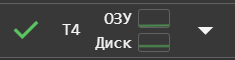

### **7.1 Создаем объект *device*, который указывает, что вычисления будут выполняться на GPU с использованием CUDA (платформа для параллельных вычислений от NVIDIA)**

In [8]:
import torch
device = torch.device("cuda")
if device.type == 'cuda':
  torch.cuda.empty_cache()

##**8. Загружаем датасет MNIST c параметрами *mnist_mean* = 0.5, *mnist_std* = 0.5, *mnist_dim* = 28:**

In [9]:
# Среднее значение для нормализации изображений из набора данных MNIST -
mnist_mean = 0.5
# Стандартное отклонение для нормализации изображений -
mnist_std = 0.5
# Размер изображений MNIST, который составляет 28 пикселей (28x28) -
mnist_dim = 28

# Рассчитываем минимальные и максимальные значения для обрезки (clip bounds) на основе заданных среднего значения, стандартного отклонения и размера изображений -
mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mnist_mean, std=mnist_std)])

mnist_tf_train = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=mnist_mean, std=mnist_std)])

mnist_tf_inv = transforms.Compose([transforms.Normalize(mean=0.0, std=np.divide(1.0, mnist_std)), transforms.Normalize(mean=np.multiply(-1.0, mnist_std), std=1.0)])

# Загружаем обучающий набор данных MNIST -
mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)
# Разделим загруженный набор данных на обучающую (mnist_train) и валидационную (mnist_val) выборки с размерами 50,000 и 10,000 соответственно -
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])
# Загружаем тестовый набор данных MNIST -
mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.25MB/s]

Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



## **9. Загружаем датасет CIFAR-10 c параметрами *cifar_mean* = [0.491, 0.482, 0.447]; *cifar_std* = [0.202,0.199, 0.201]; *cifar_dim* = 32:**

In [10]:
# Средние значения для нормализации изображений из набора данных CIFAR-10 по каждому из трех цветовых каналов (RGB) -
cifar_mean = [0.491, 0.482, 0.447]
# Стандартные отклонения для нормализации изображений по каждому из цветовых каналов -
cifar_std = [0.202, 0.199, 0.201]
# Размер изображений CIFAR-10, который составляет 32 пикселя (32x32) -
cifar_dim = 32
# Рассчитываем минимальные и максимальные значения для обрезки (clip bounds) на основе среднего значения, стандартного отклонения и размера изображений -
cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=cifar_mean, std=cifar_std)])

cifar_tf_train = transforms.Compose([transforms.RandomCrop(size=cifar_dim, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=cifar_mean, std=cifar_std)])

cifar_tf_inv = transforms.Compose([transforms.Normalize(mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)), transforms.Normalize(mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])
# Загружаем обучающий набор данных CIFAR-10 -
cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)
# Разделяем загруженный набор данных на обучающую (cifar_train) и валидационную (cifar_val) выборки с размерами 40,000 и 10,000 соответственно -
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])
# Загружаем тестовый набор данных CIFAR-10 -
cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)
# Определяем список классов (категорий) изображений в наборе данных CIFAR-10 -
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


## **10. Выполняем настройку и загрузку DataLoader с параметрами *batch_size* = 64; *workers* = 4:**

In [11]:
# Размер пакета (batch size), который указывает, сколько примеров будет загружаться за один раз -
batch_size = 64
# Количество потоков (workers) для загрузки данных -
workers = 4
# Создаем загрузчики данных для обучающего, валидацонного и тестового наборов MNIST -
mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)
# Создаем загрузчики данных для обучающего, валидацонного и тестового наборов CIFAR -
cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## **11. Задаём гиперпараметры для DeepFool:**

In [12]:
# Устанавливаем размер пакета равный 10. Это означает, что за один раз будет обрабатываться 10 примеров данных -
deep_batch_size = 10
# Задаем количество классов, которое равно 10 -
deep_num_classes = 10
# Параметр может использоваться для управления тем, насколько модель может "перепрыгнуть" через оптимальное значение во время обучения -
deep_overshoot = 0.02
# Задаем максимальное количество итераций для процесса обучения, равное 50 -
deep_max_iters = 50
# Создаем список, который содержит все ранее определенные параметры -
deep_args = [deep_batch_size, deep_num_classes, deep_overshoot, deep_max_iters]

## **12. Загружаем и оцениваем стойкость модели LeNet к FGSM и DeepFool атакам на основе датасета CIFAR-10:**

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


<ipython-input-13-049e3d59bbbf>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
/usr/local/lib/python3.10

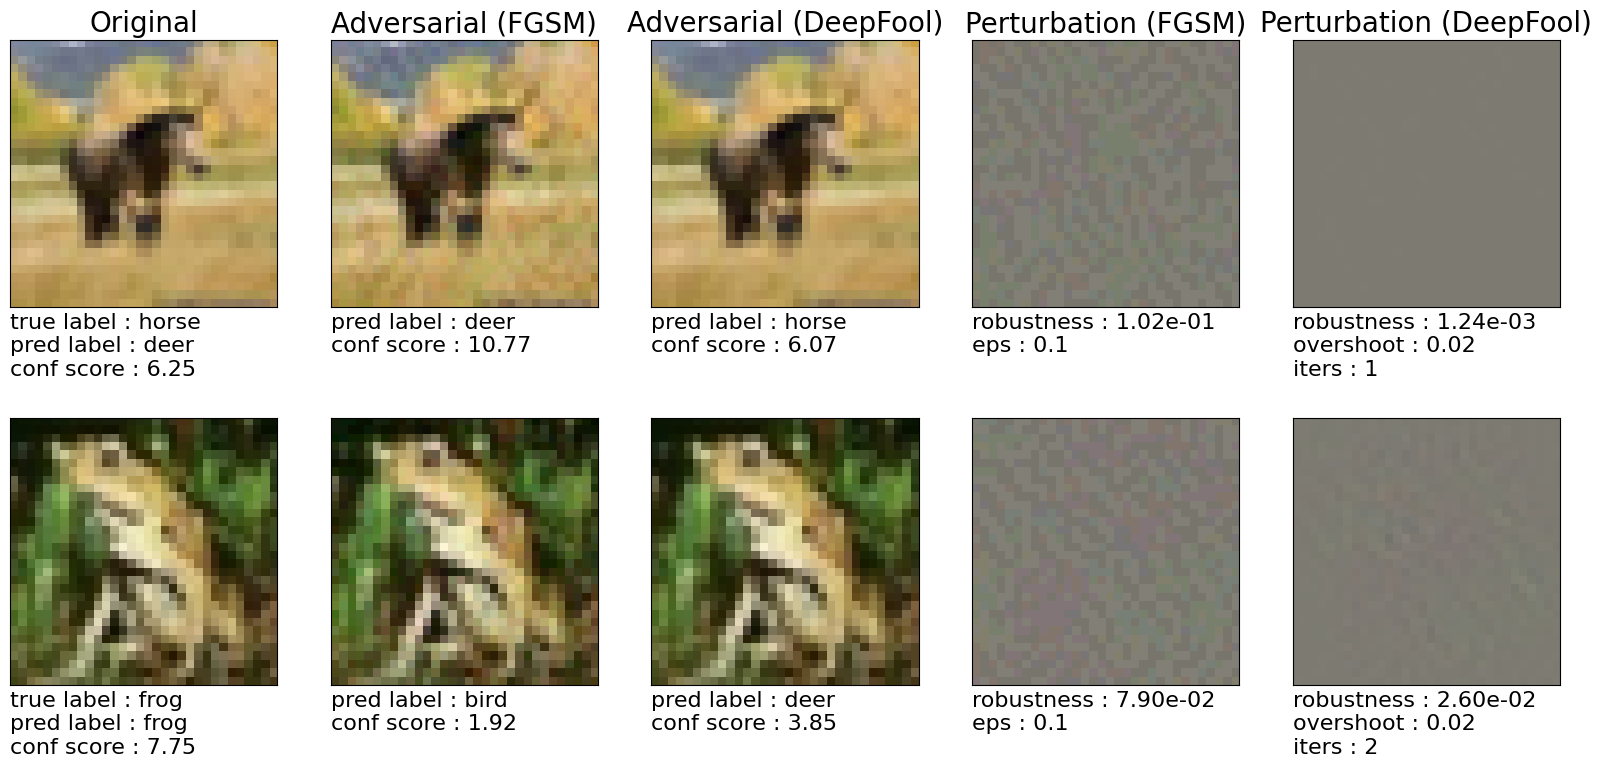

In [13]:
# Задаем значение, которое представляет собой величину искажения (perturbation) для атаки FGSM -
fgsm_eps = 0.1
# Создаем экземпляр модели -
model = LeNet_CIFAR().to(device)
# Загружаем предварительно обученные веса модели из файла cifar_lenet.pth, который находится в директории weights/clean -
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
# Вызываем функция, которая оценивает модель на устойчивость к атаке FGSM -
evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
# Вызываем функция evaluate_attack, но теперь для оценки устойчивости к атаке DeepFool -
evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
# Вызываем функция display_attack, которая визуализирует результаты атак -
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)
# Проверяем тип устройства. Если это GPU (CUDA), вызывается метод torch.cuda.empty_cache(), который очищает неиспользуемую память в кэше CUDA -
if device.type == 'cuda':
  torch.cuda.empty_cache()

## **13. Загружаем и оцениваем стойкость модели NiN к FGSM и DeepFool атакам на основе датасета CIFAR-10:**

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


<ipython-input-14-703c0692a56a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

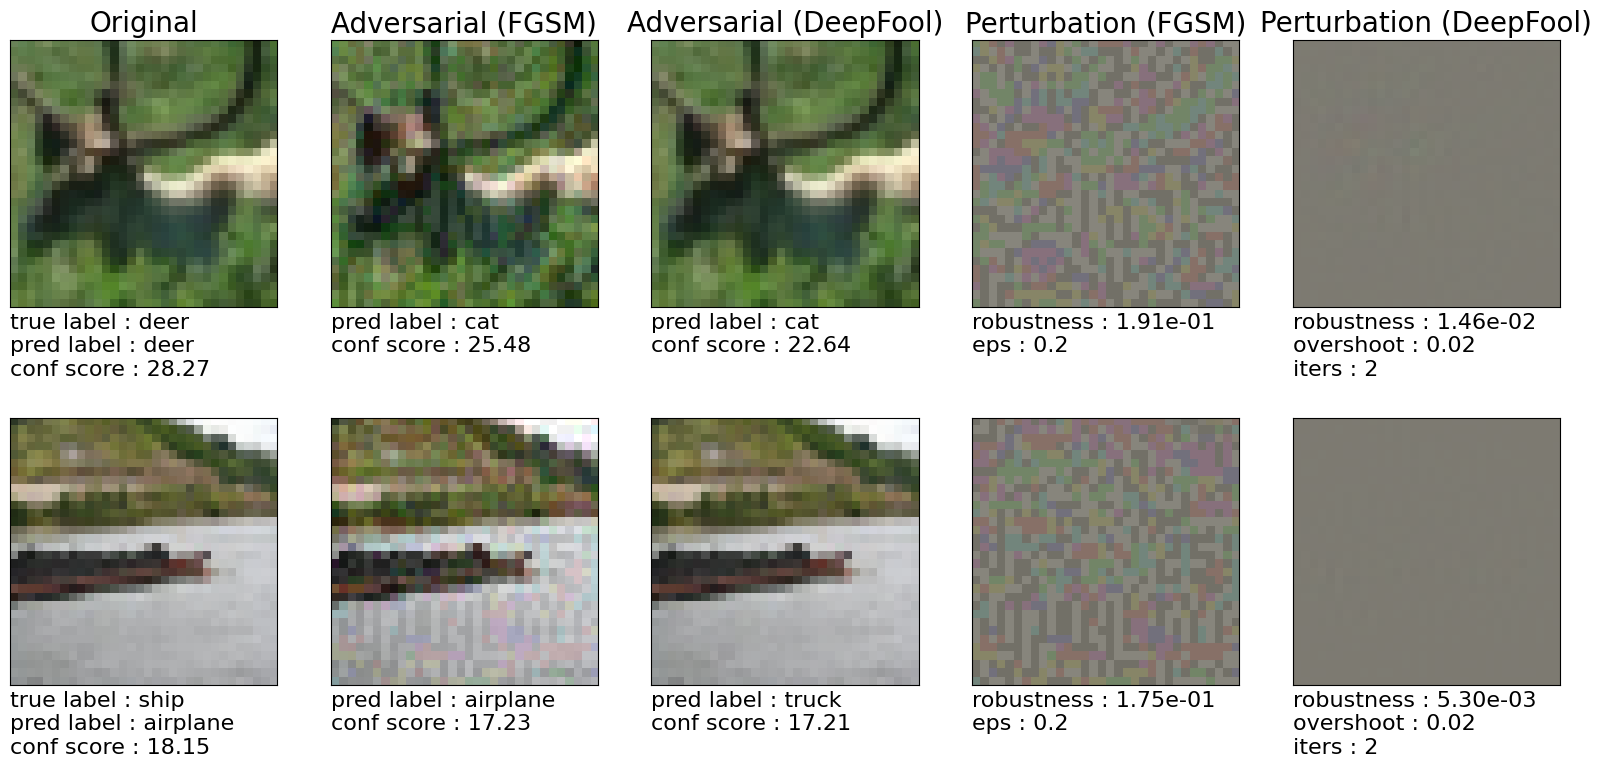

In [14]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
evaluate_attack('cifar_nin_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)
if device.type == 'cuda':
  torch.cuda.empty_cache()

## **14. После этого загружаем и оцениваем стойкость модели FCNet к FGSM и DeepFool атакам на основе датасета MNIST:**

FGSM Test Error : 87.08%
FGSM Robustness : 1.56e-01
FGSM Time (All Images) : 0.15 s
FGSM Time (Per Image) : 14.99 us

DeepFool Test Error : 97.92%
DeepFool Robustness : 6.78e-02
DeepFool Time (All Images) : 141.81 s
DeepFool Time (Per Image) : 14.18 ms


<ipython-input-15-2ee23b0d4317>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
/usr/local/lib/python3.10/di

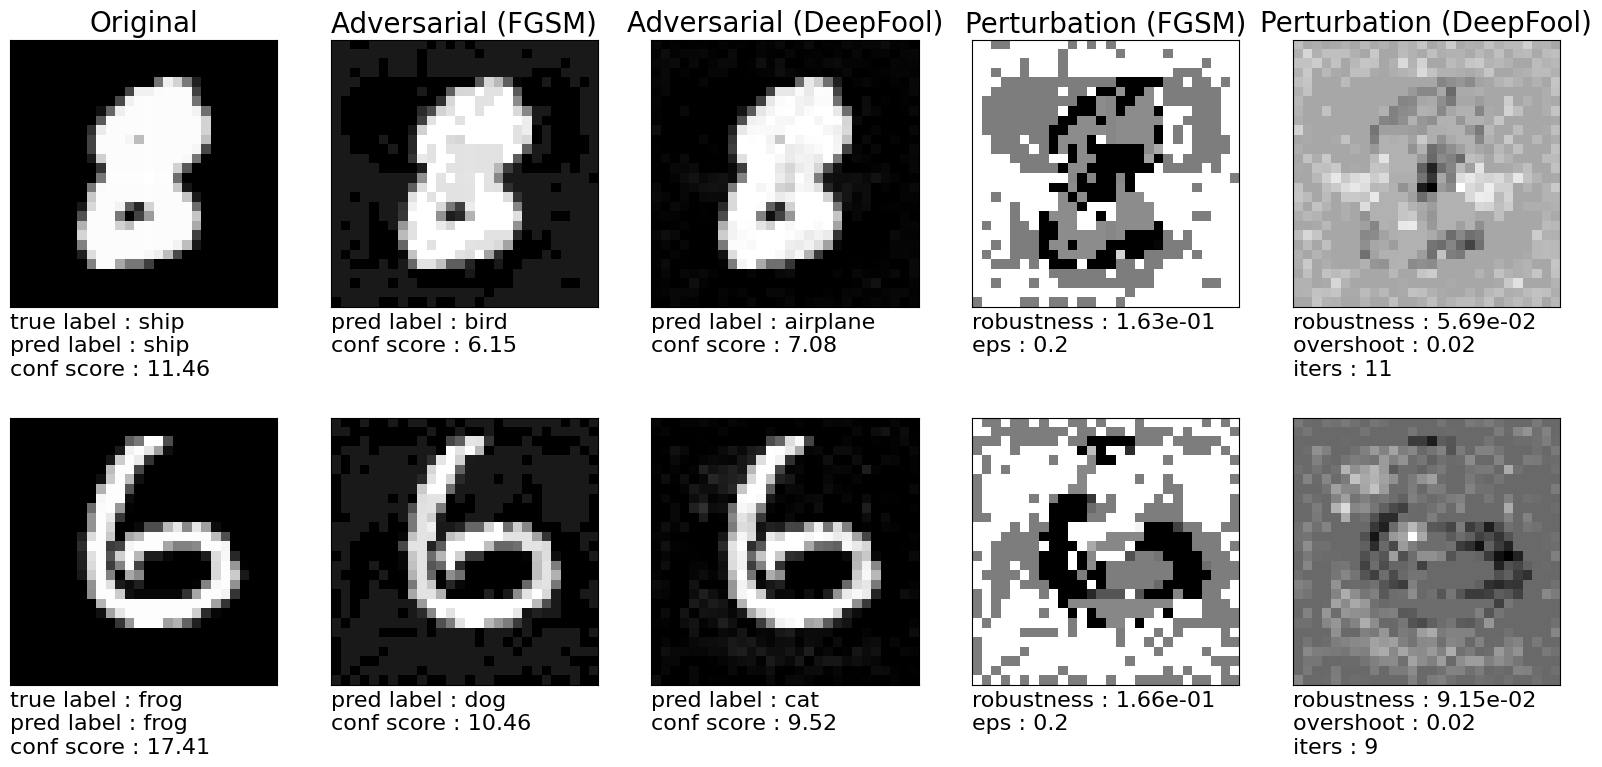

In [15]:
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
evaluate_attack('mnist_fc_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('mnist_fc_deepfool.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, deep_args, is_fgsm=False)
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)
if device.type == 'cuda':
  torch.cuda.empty_cache()

## **14. Также загружаем и оцениваем стойкость модели LeNet к FGSM и DeepFool атакам на основе датасета MNIST:**

FGSM Test Error : 87.89%
FGSM Robustness : 4.58e-01
FGSM Time (All Images) : 0.29 s
FGSM Time (Per Image) : 28.86 us

DeepFool Test Error : 98.74%
DeepFool Robustness : 9.64e-02
DeepFool Time (All Images) : 193.32 s
DeepFool Time (Per Image) : 19.33 ms


<ipython-input-16-167e10ee009f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.10

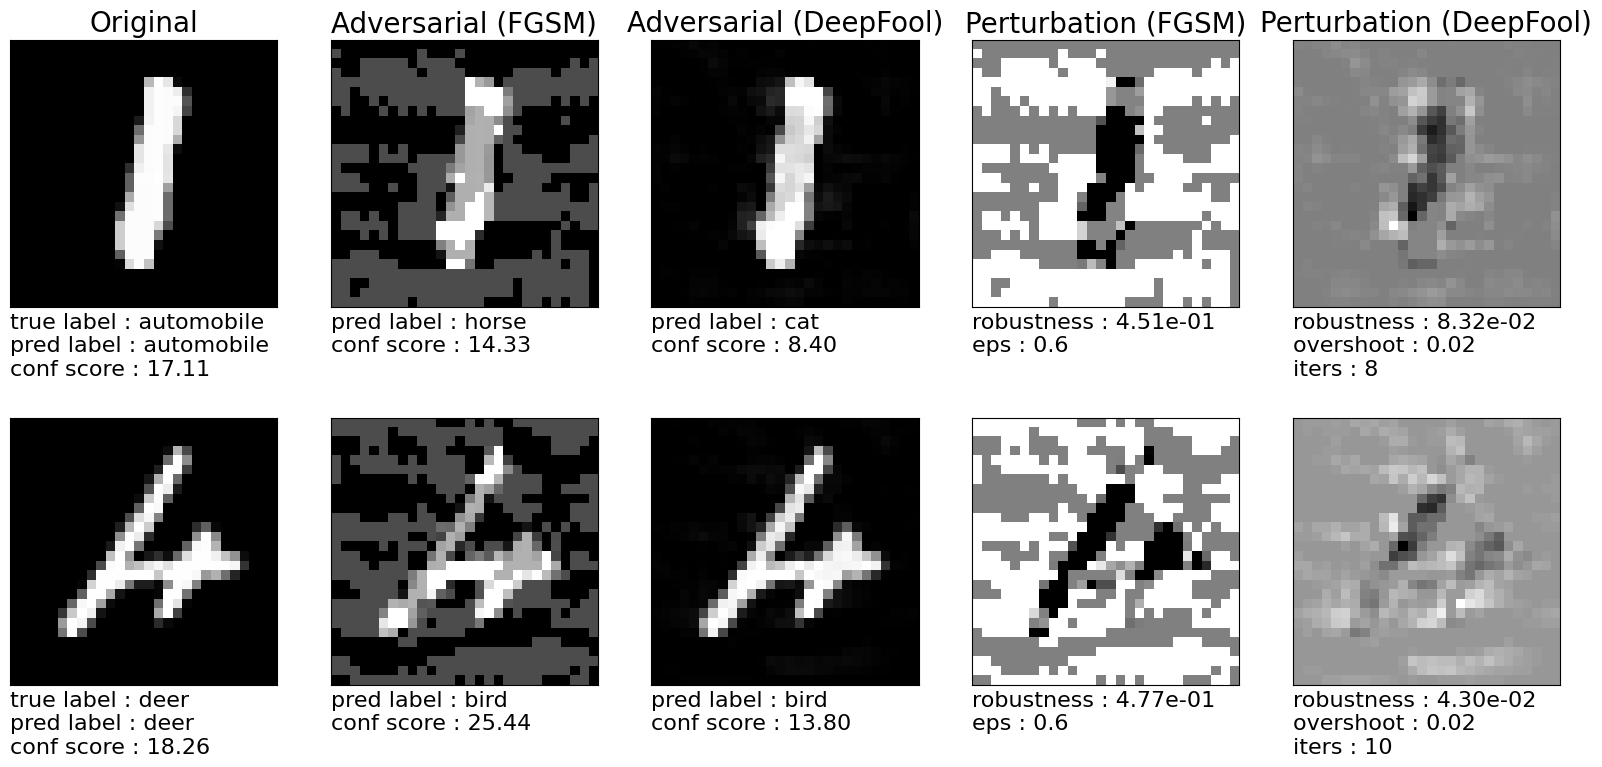

In [16]:
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
evaluate_attack('mnist_lenet_fgsm.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('mnist_lenet_deepfool.csv', 'results', device, model, mnist_loader_test, mnist_min, mnist_max, deep_args, is_fgsm=False)
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)
if device.type == 'cuda':
  torch.cuda.empty_cache()

## **15. Приступаем к перебору значений параметра *fgsm_eps_mass* = (0.001, 0.02, 0.5, 0.9, 10) и оцениванию влияния параметра *eps* для сетей FC и LeNet на датасете MNIST, а также NiN и LeNet на датасете CIFAR:**

## **15.1 Задаем массив значений для параметра *fgsm_eps_mass*:**

In [17]:
fgsm_eps_mass=[0.001, 0.02, 0.5, 0.9, 10]

## **15.2 Анализируем различные значения переменной *eps* и сравниваем ошибки нейронной сети (модель - NiN, датасет - CIFAR):**

In [18]:
model = Net().to(device)
for fgsm_eps in fgsm_eps_mass:
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
  print('')
  print('')
  print('fgsm eps = ', fgsm_eps)
  filename = 'cifar_nin_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(filename, 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
  print('')
  if device.type == 'cuda':
    torch.cuda.empty_cache()



fgsm eps =  0.001


<ipython-input-18-4329633eb244>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 10.12%
FGSM Robustness : 8.92e-04
FGSM Time (All Images) : 1.33 s
FGSM Time (Per Image) : 132.55 us



fgsm eps =  0.02


<ipython-input-18-4329633eb244>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 30.76%
FGSM Robustness : 1.78e-02
FGSM Time (All Images) : 1.06 s
FGSM Time (Per Image) : 105.65 us



fgsm eps =  0.5


<ipython-input-18-4329633eb244>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 82.67%
FGSM Robustness : 4.40e-01
FGSM Time (All Images) : 1.04 s
FGSM Time (Per Image) : 104.18 us



fgsm eps =  0.9


<ipython-input-18-4329633eb244>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 84.62%
FGSM Robustness : 7.79e-01
FGSM Time (All Images) : 1.25 s
FGSM Time (Per Image) : 124.52 us



fgsm eps =  10


<ipython-input-18-4329633eb244>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 87.50%
FGSM Robustness : 2.46e+00
FGSM Time (All Images) : 1.06 s
FGSM Time (Per Image) : 105.56 us



**До значения параметра *eps* равного 0.02 ошибка FGSM растет плавно (от 10% до 30%), но при значении >= 0.5 она резко возрастает до 82%**

#### **15.2.1 Визуализируем как значение переменной *eps* влияет на входные изображения при атаке:**



Изображения для eps = 0.001


<ipython-input-19-bd5bc5107c94>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
/usr/local/lib/python3.10/d

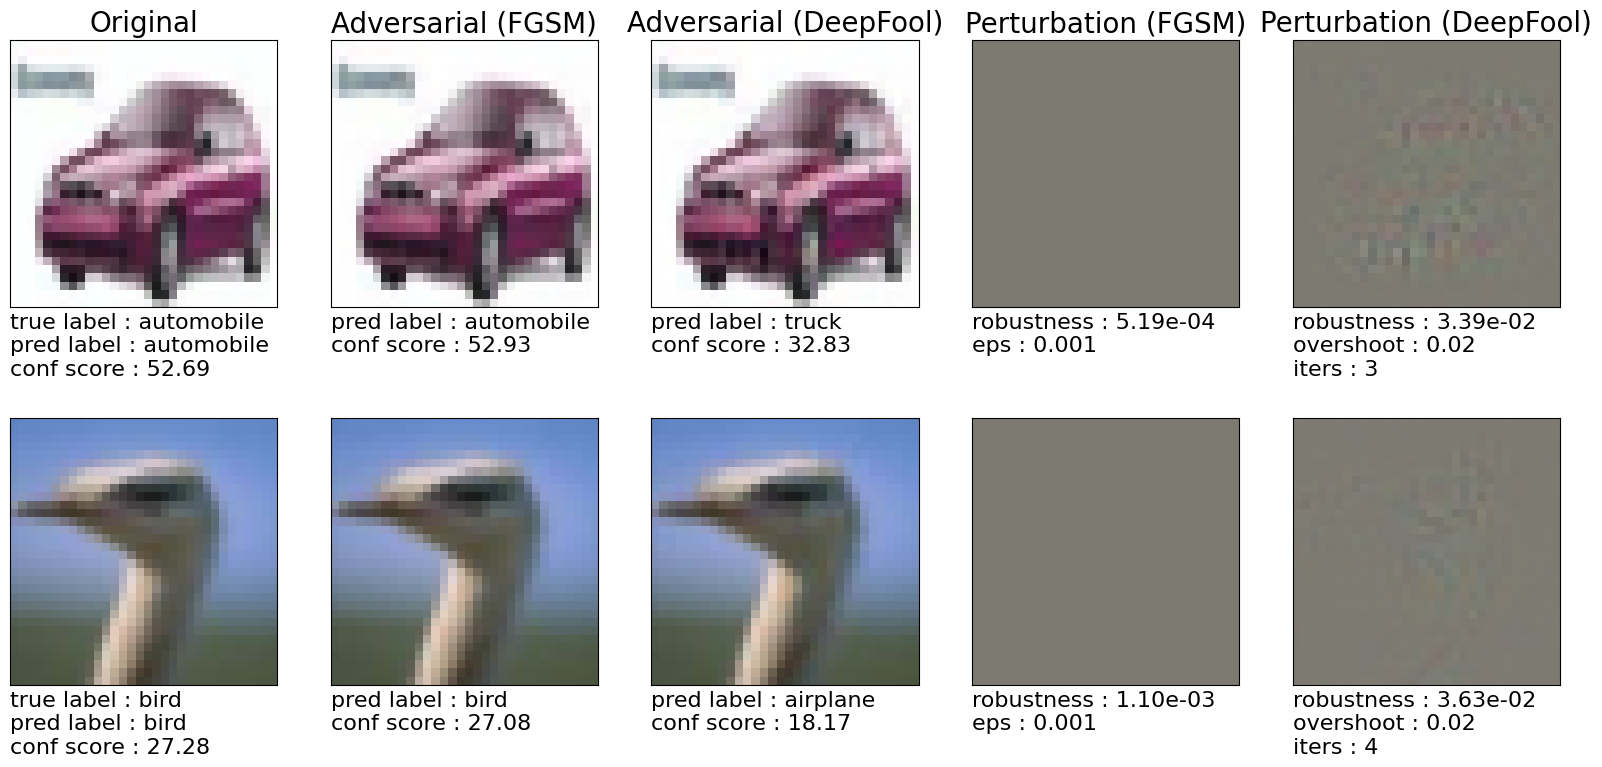



Изображения для eps = 0.02


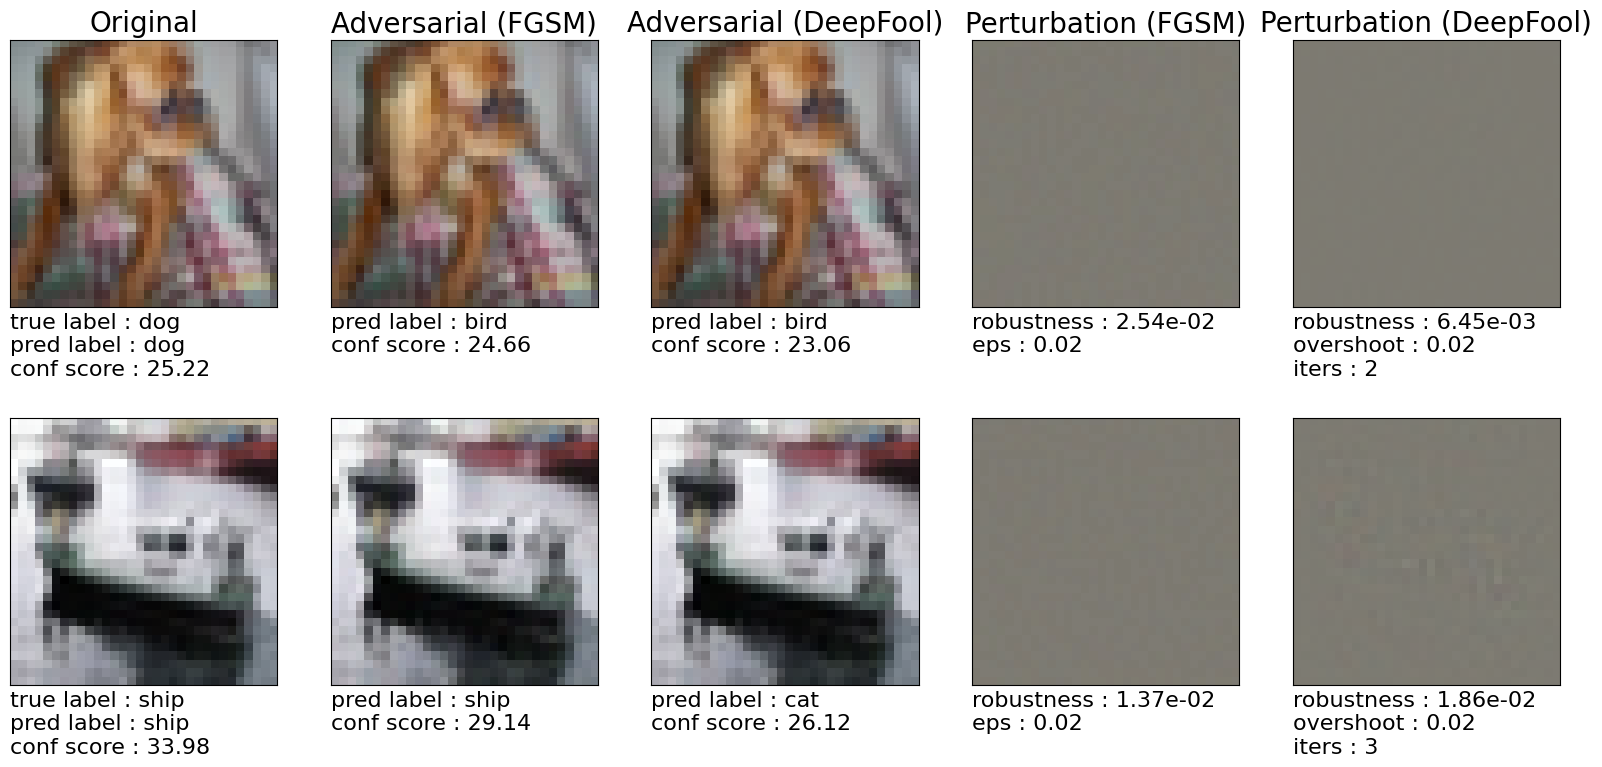



Изображения для eps = 0.5


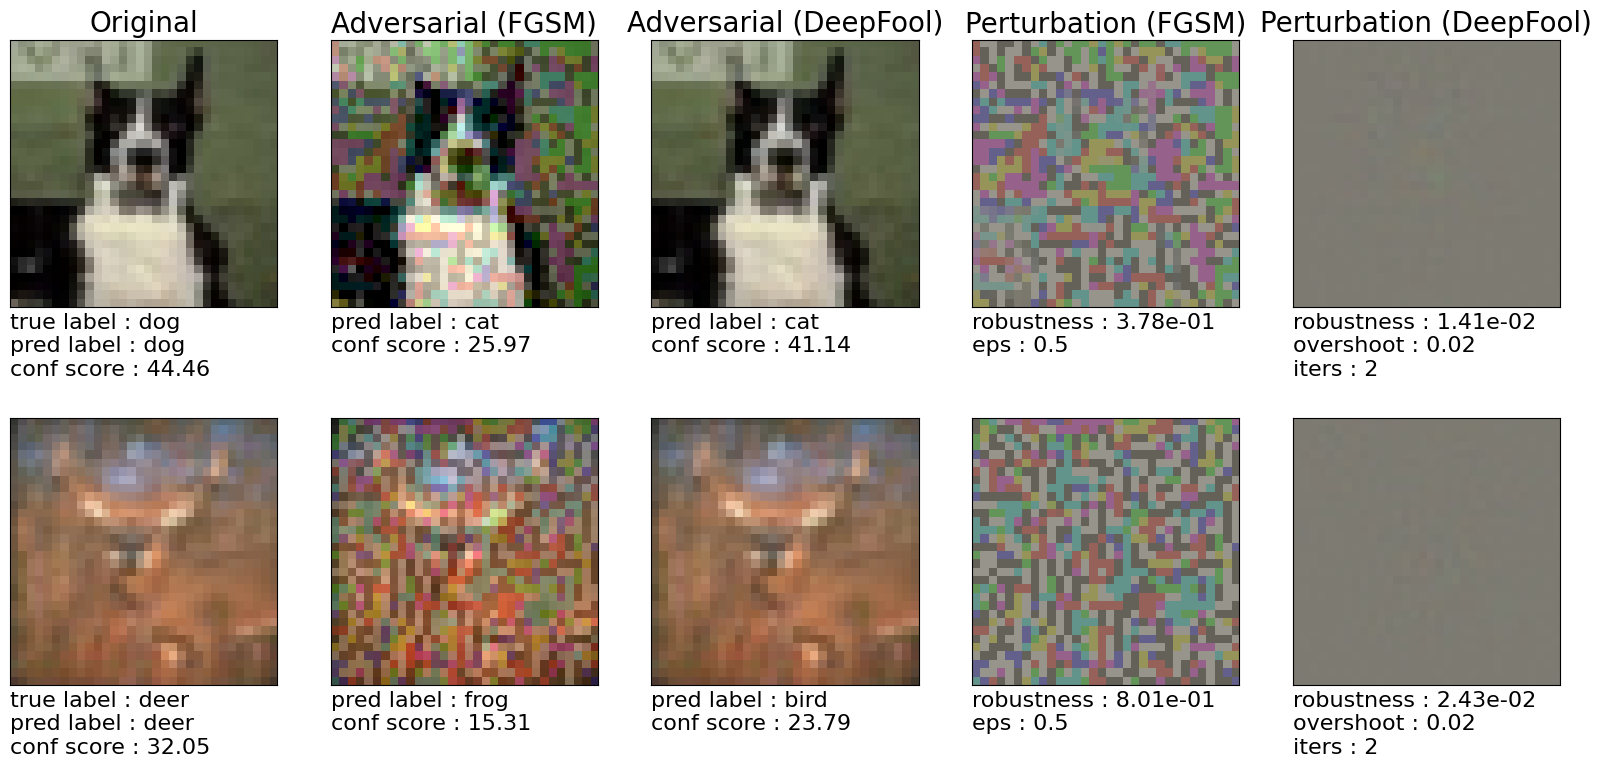



Изображения для eps = 0.9


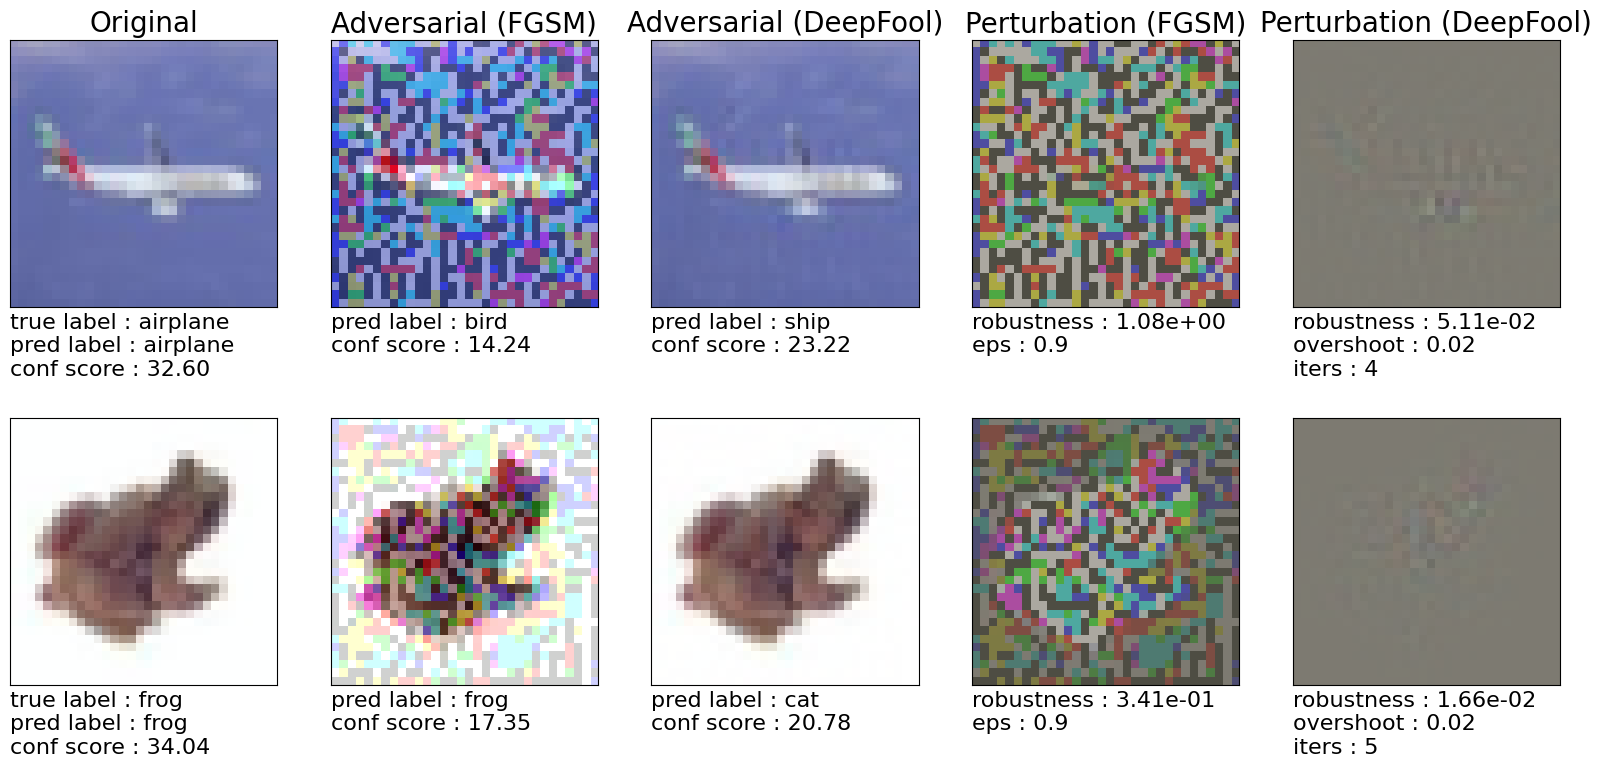



Изображения для eps = 10


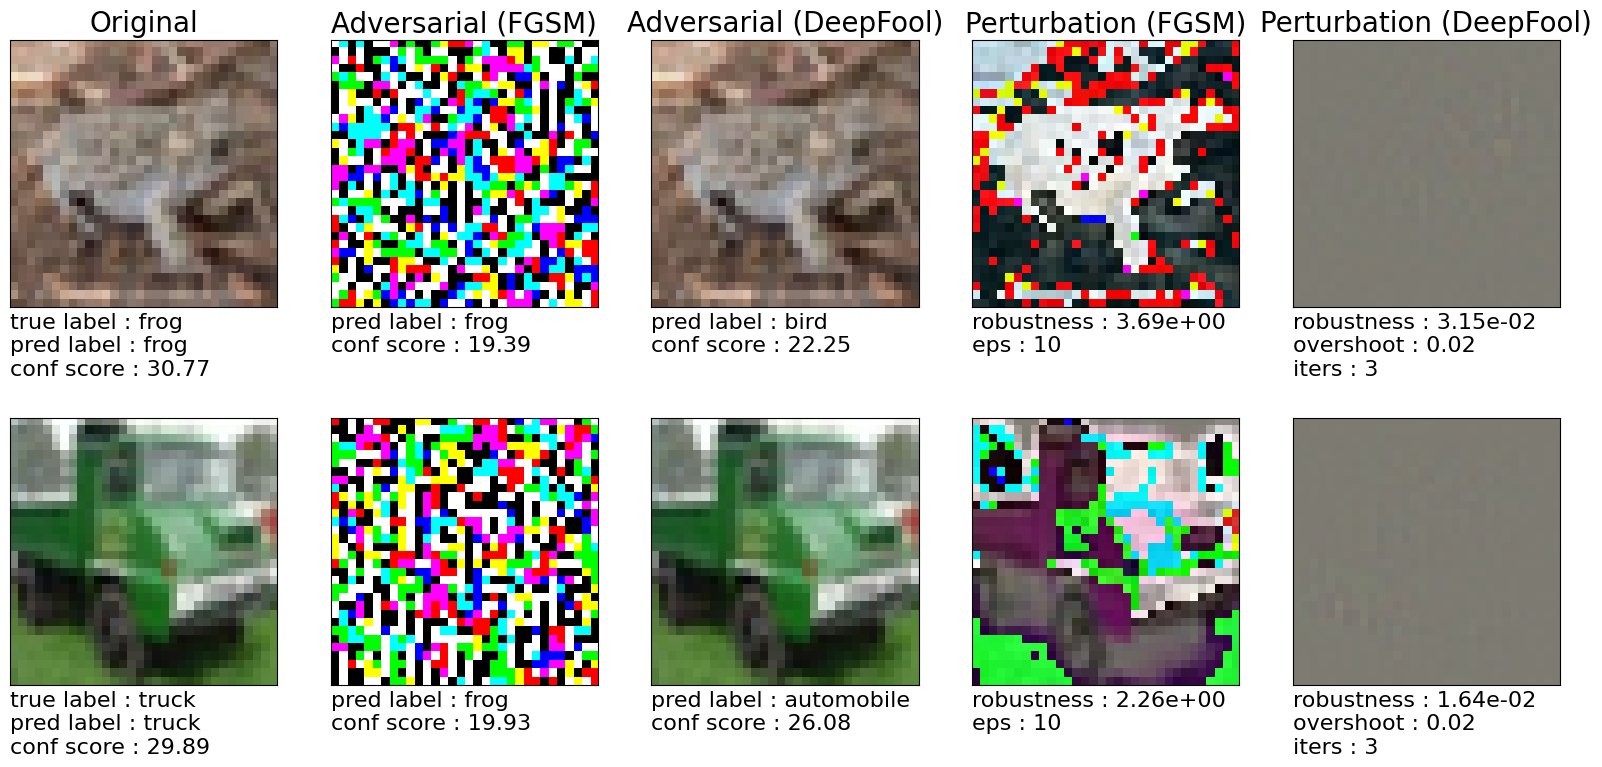

In [19]:
model = Net().to(device)
for fgsm_eps in fgsm_eps_mass:
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
  print('')
  print('')
  print(f"Изображения для eps = {fgsm_eps}")

  display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)

  if device.type == 'cuda':
      torch.cuda.empty_cache()

**Значения параметра *eps* <= 0.02 почти не несут никаких искажений и незначительно ухудшают работу нейросети, а >= 0.5 уже заметно изменяет изображение и коордмнально ухудшают работу**

### **15.3 Анализируем различные значения переменной *eps* и сравниваем ошибки нейронной сети (модель - LeNet, датасет - CIFAR):**


In [20]:
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
for fgsm_eps in fgsm_eps_mass:
  print('')
  print('')
  print('fgsm eps = ', fgsm_eps)
  filename = 'cifar_lenet_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(filename, 'results',
                  device, model, cifar_loader_test,
                  cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
  if device.type == 'cuda':
      torch.cuda.empty_cache()



fgsm eps =  0.001


<ipython-input-20-48c32ce70303>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
/usr/local/lib/python3.10

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 22.72%
FGSM Robustness : 8.92e-04
FGSM Time (All Images) : 1.26 s
FGSM Time (Per Image) : 126.42 us


fgsm eps =  0.02


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 47.76%
FGSM Robustness : 1.78e-02
FGSM Time (All Images) : 1.29 s
FGSM Time (Per Image) : 129.14 us


fgsm eps =  0.5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 95.17%
FGSM Robustness : 4.40e-01
FGSM Time (All Images) : 1.42 s
FGSM Time (Per Image) : 141.85 us


fgsm eps =  0.9


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 92.04%
FGSM Robustness : 7.80e-01
FGSM Time (All Images) : 1.11 s
FGSM Time (Per Image) : 111.07 us


fgsm eps =  10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 89.90%
FGSM Robustness : 2.47e+00
FGSM Time (All Images) : 1.13 s
FGSM Time (Per Image) : 112.95 us


**До значения параметра *eps* равного 0.02 ошибка FGSM растет плавно (от 22% до 47%), но при значении = 0.5 она резко возрастает до 95%, однако при значниях > 0.5 ошибка начинает уменьшаться (при *eps* = 0.9 ошибка равна 92%)**

#### **15.3.1 Визуализируем как значение переменной *eps* влияет на входные изображения при атаке:**



Отображение изображений для epsilon: 0.001


<ipython-input-21-030d213b8a7c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
/usr/local/lib/python3.10

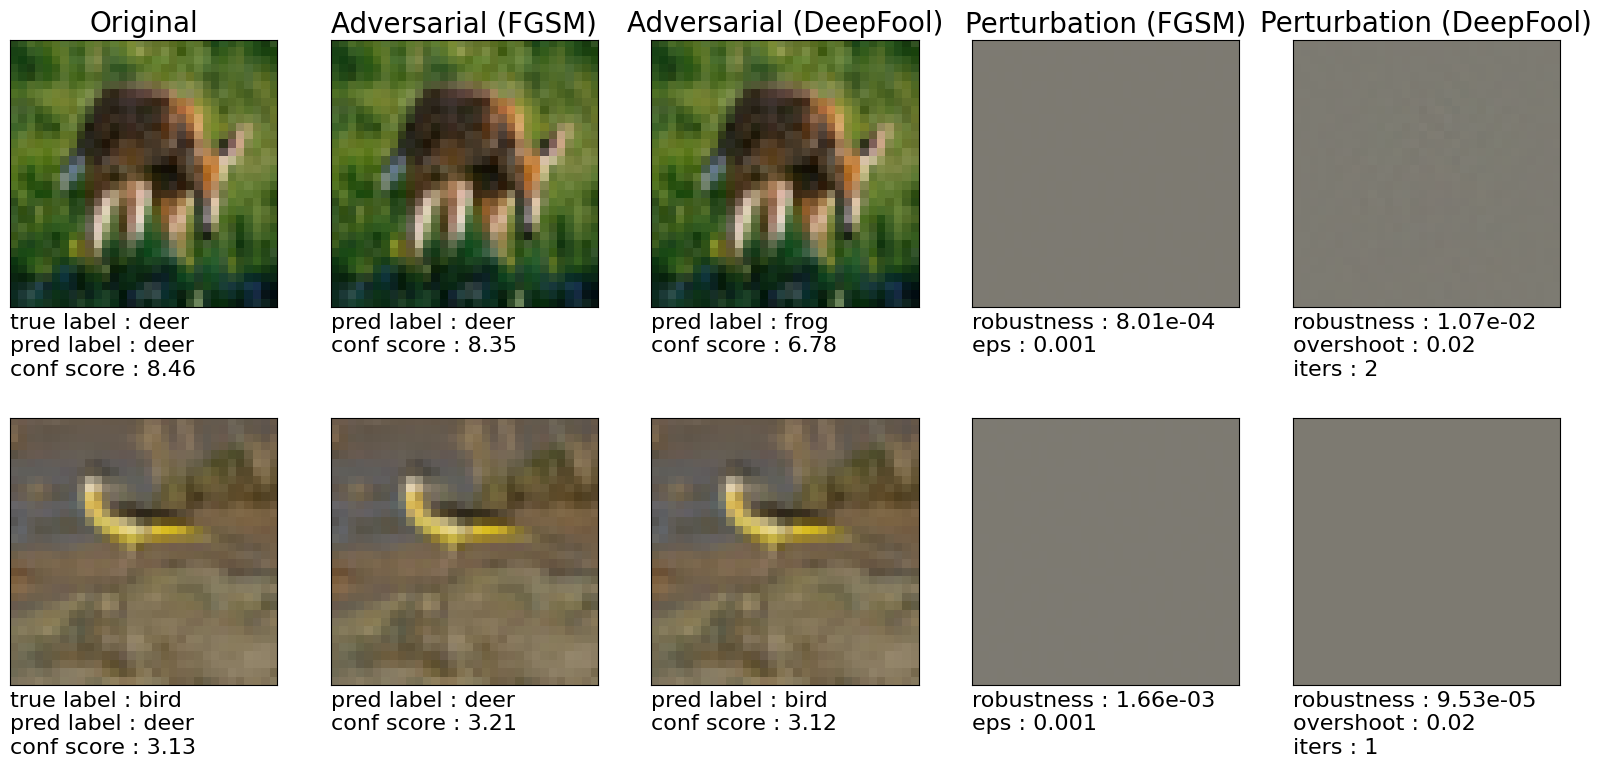



Отображение изображений для epsilon: 0.02


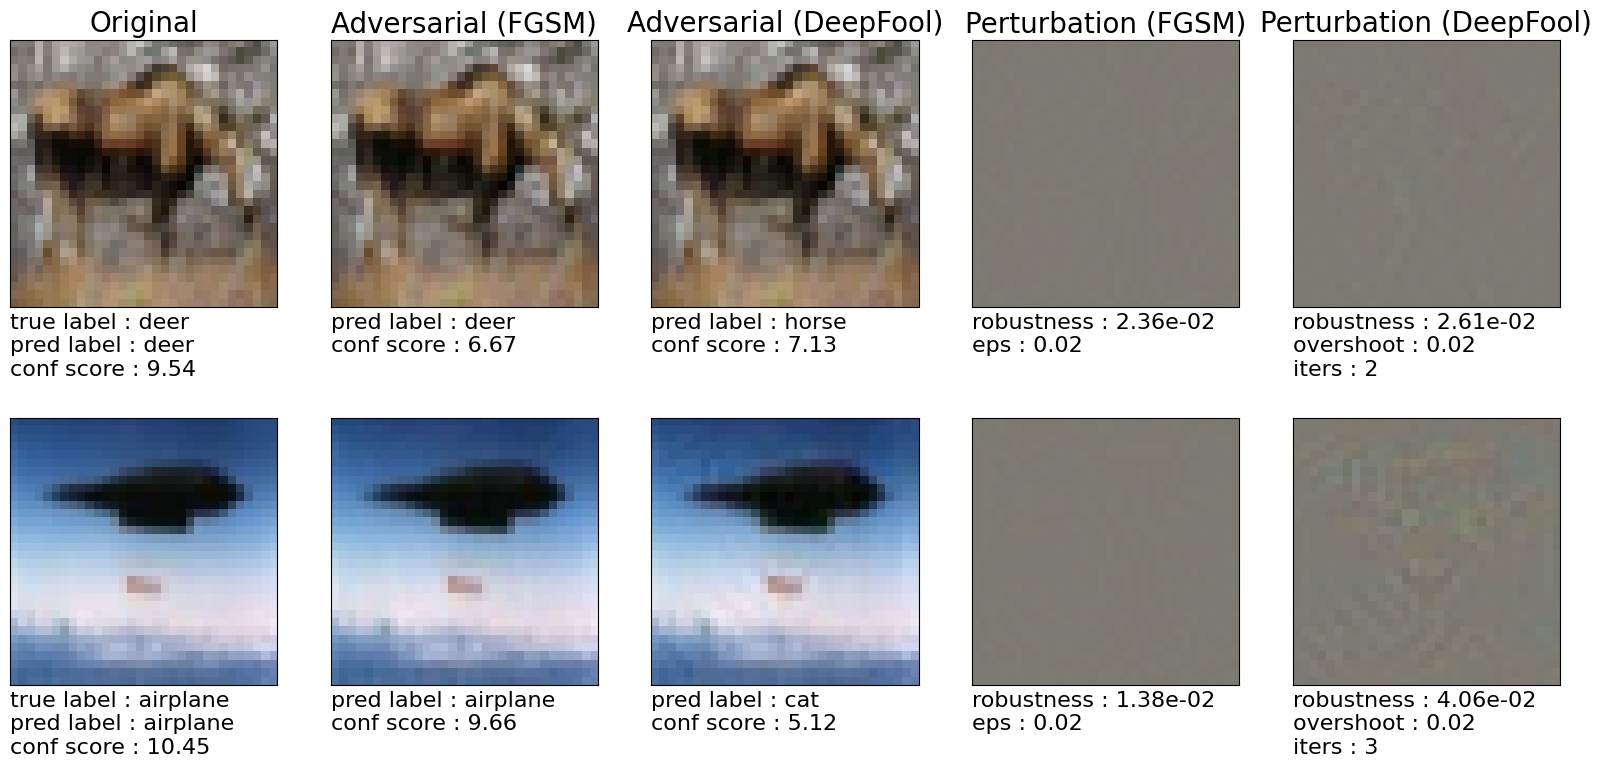



Отображение изображений для epsilon: 0.5


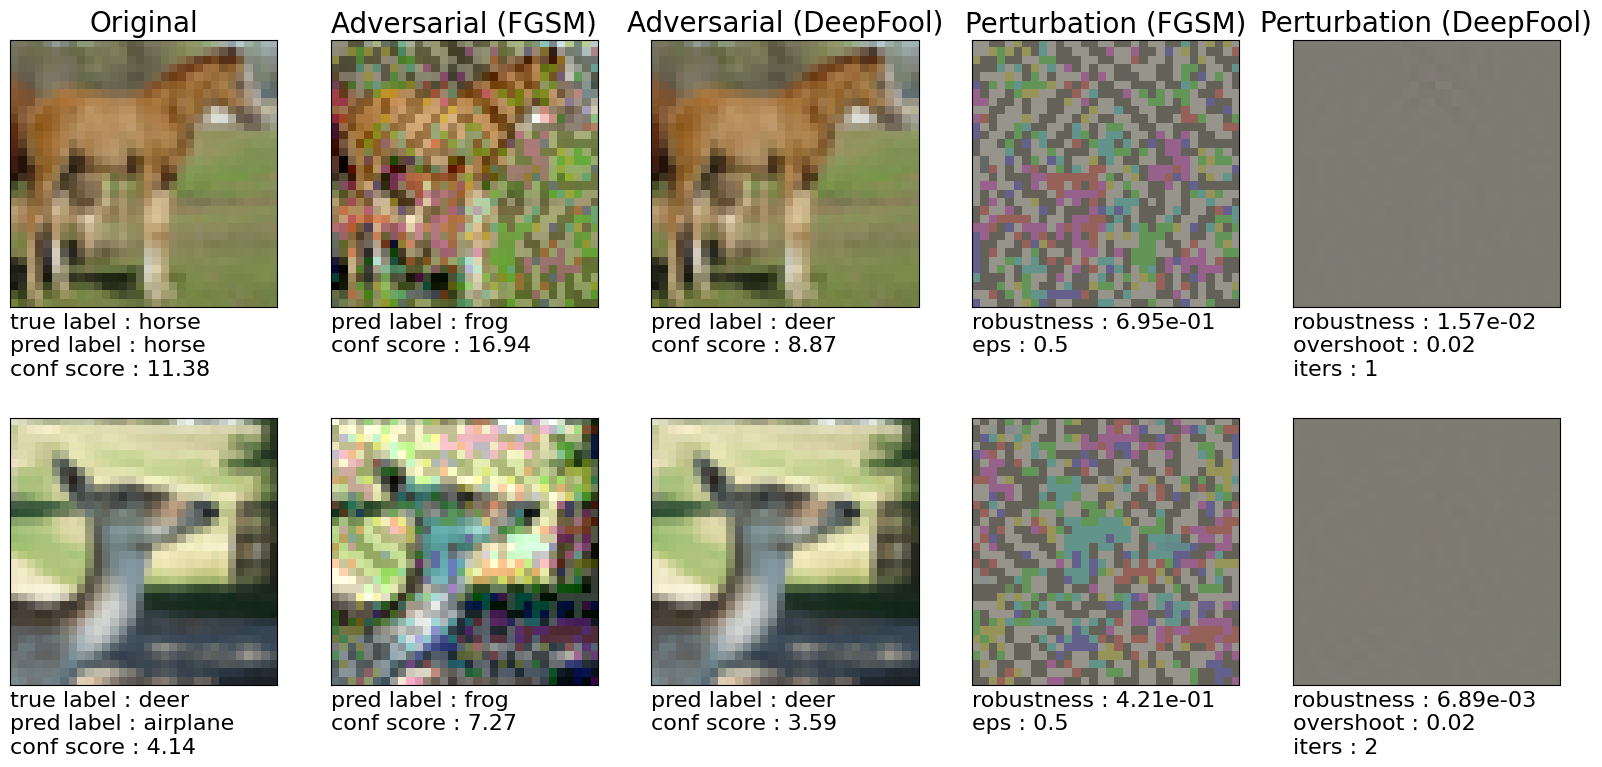



Отображение изображений для epsilon: 0.9


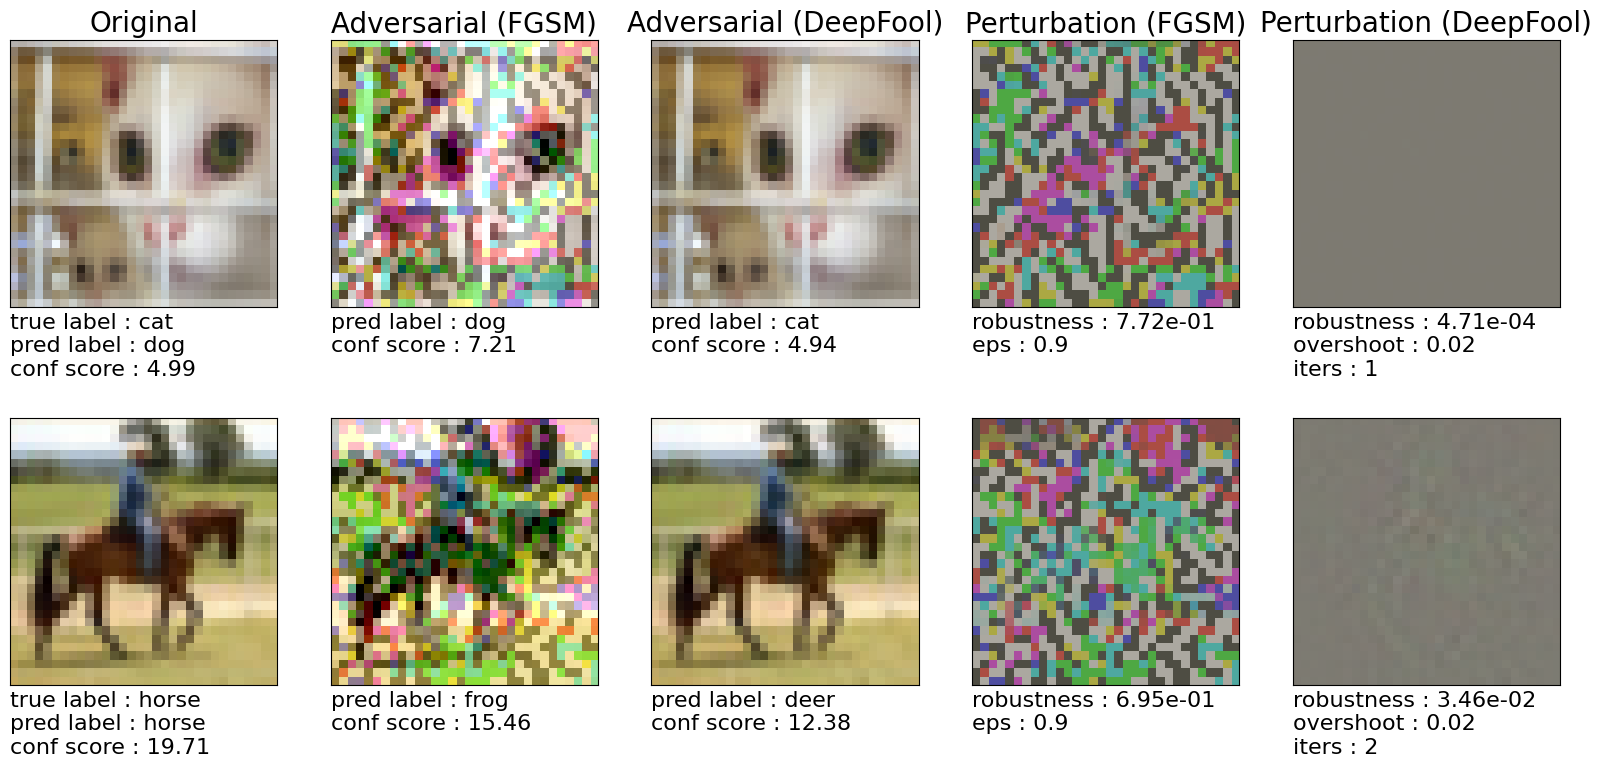



Отображение изображений для epsilon: 10


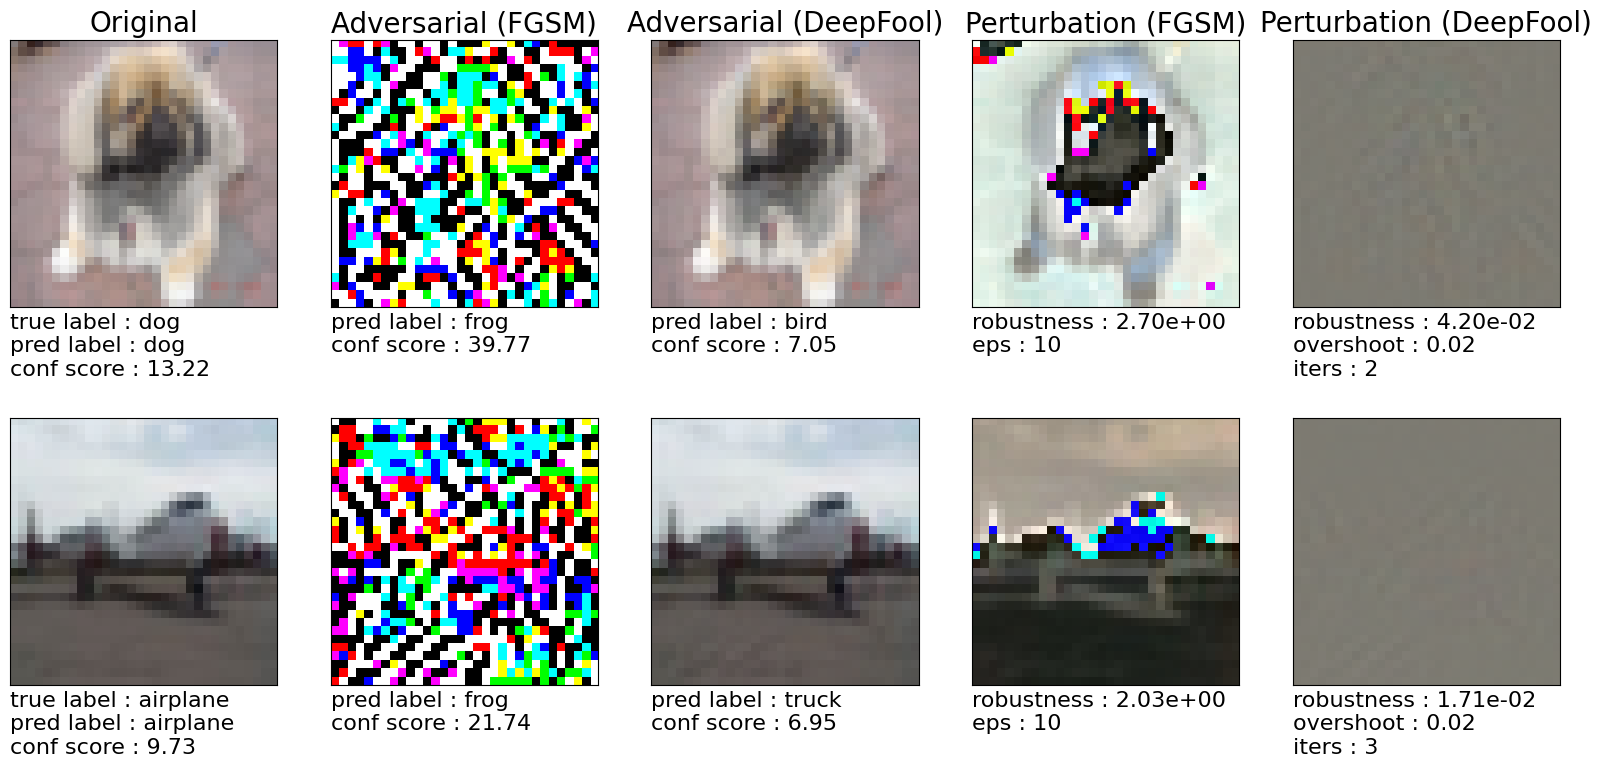

In [21]:
model = LeNet_CIFAR().to(device)
for fgsm_eps in fgsm_eps_mass:
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
  print('')
  print('')
  print(f"Отображение изображений для epsilon: {fgsm_eps}")

  display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)

  if device.type == 'cuda':
      torch.cuda.empty_cache()

**Аналогично прошлой модели значения параметра *eps* <= 0.02 почти не несут никаких искажений и незначительно ухудшают работу нейросети, а >= 0.5 уже заметно изменяет изображение и коордмнально ухудшают работу**

### **15.4 Анализируем различные значения переменной *eps* и сравниваем ошибки нейронной сети (модель - FC, датасет - MNIST):**


In [22]:
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
for fgsm_eps in fgsm_eps_mass:
  print('')
  print('')
  print('fgsm eps = ', fgsm_eps)
  filename = 'mnist_fc_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(filename, 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
  if device.type == 'cuda':
      torch.cuda.empty_cache()



fgsm eps =  0.001


<ipython-input-22-a6534b2eec4c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
/usr/local/lib/python3.10/di

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 3.07%
FGSM Robustness : 8.08e-04
FGSM Time (All Images) : 0.66 s
FGSM Time (Per Image) : 66.30 us


fgsm eps =  0.02


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 5.54%
FGSM Robustness : 1.60e-02
FGSM Time (All Images) : 0.54 s
FGSM Time (Per Image) : 53.59 us


fgsm eps =  0.5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.21%
FGSM Robustness : 3.86e-01
FGSM Time (All Images) : 0.54 s
FGSM Time (Per Image) : 54.46 us


fgsm eps =  0.9


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.87%
FGSM Robustness : 6.86e-01
FGSM Time (All Images) : 0.58 s
FGSM Time (Per Image) : 57.97 us


fgsm eps =  10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.87%
FGSM Robustness : 1.47e+00
FGSM Time (All Images) : 0.58 s
FGSM Time (Per Image) : 58.11 us


**До значения параметра *eps* равного 0.02 ошибка FGSM растет плавно и очень медленно (от 3% до 5%), но при значении = 0.5 она резко возрастает до 99%  и при значниях > 0.5 ошибка продолжает увеличиваться (при *eps* = 0.9 ошибка равна 99,8%)**

#### **15.4.1 Визуализируем как значение переменной *eps* влияет на входные изображения при атаке:**



Отображение изображений для epsilon: 0.001


<ipython-input-23-4a0088952667>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
/usr/local/lib/python3.10/di

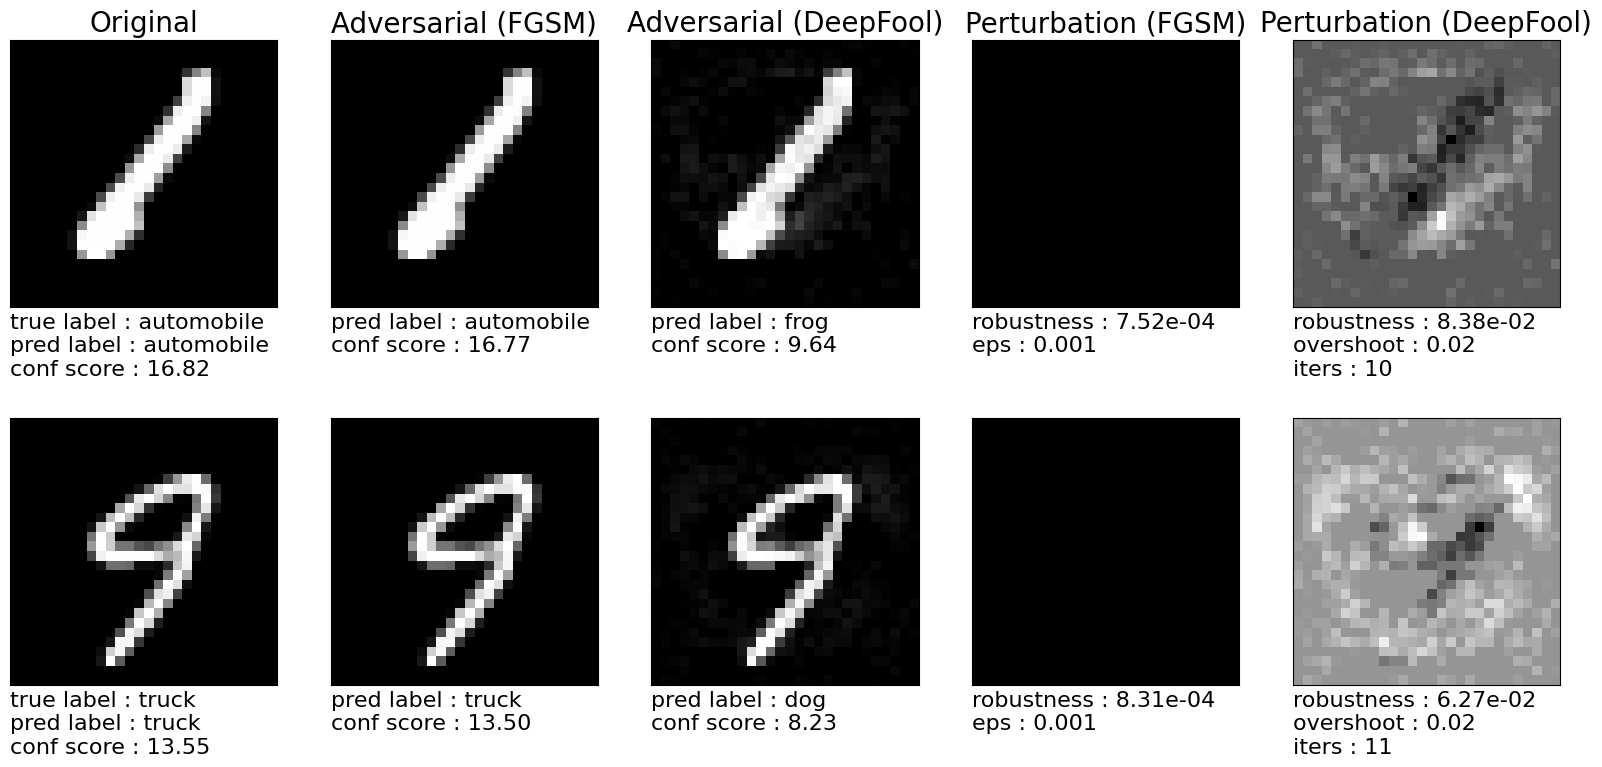



Отображение изображений для epsilon: 0.02


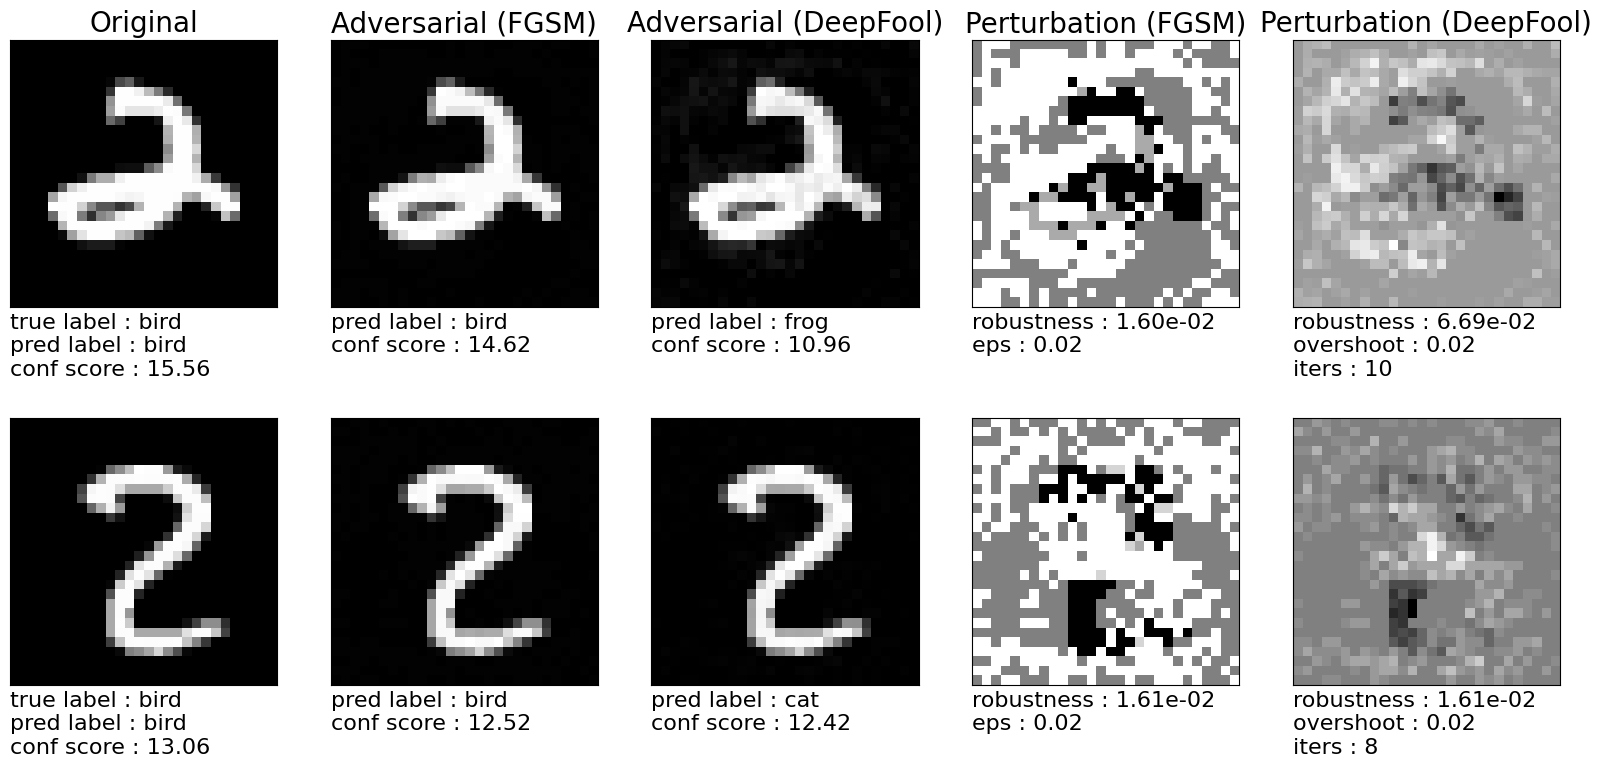



Отображение изображений для epsilon: 0.5


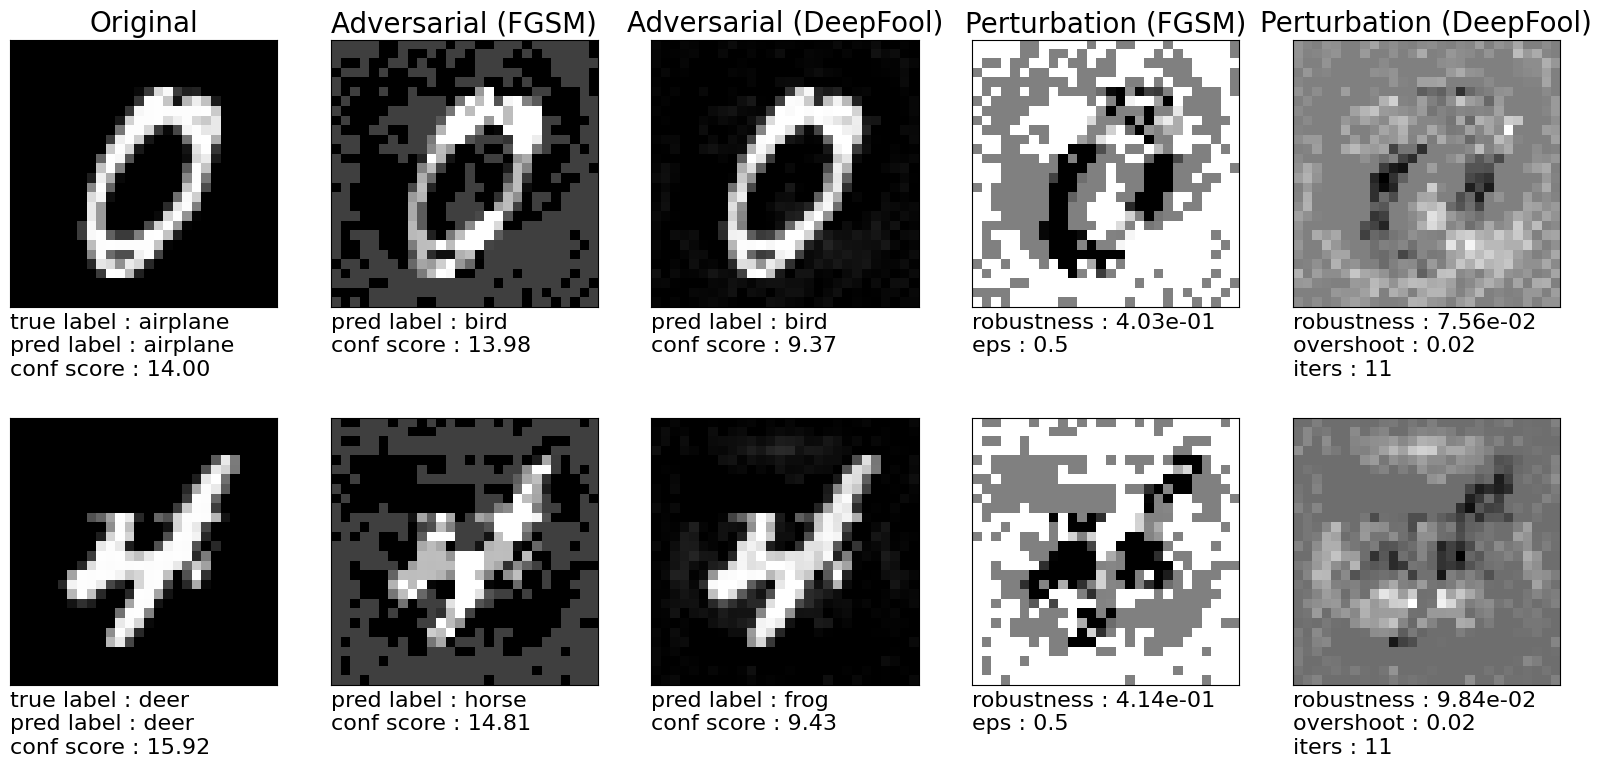



Отображение изображений для epsilon: 0.9


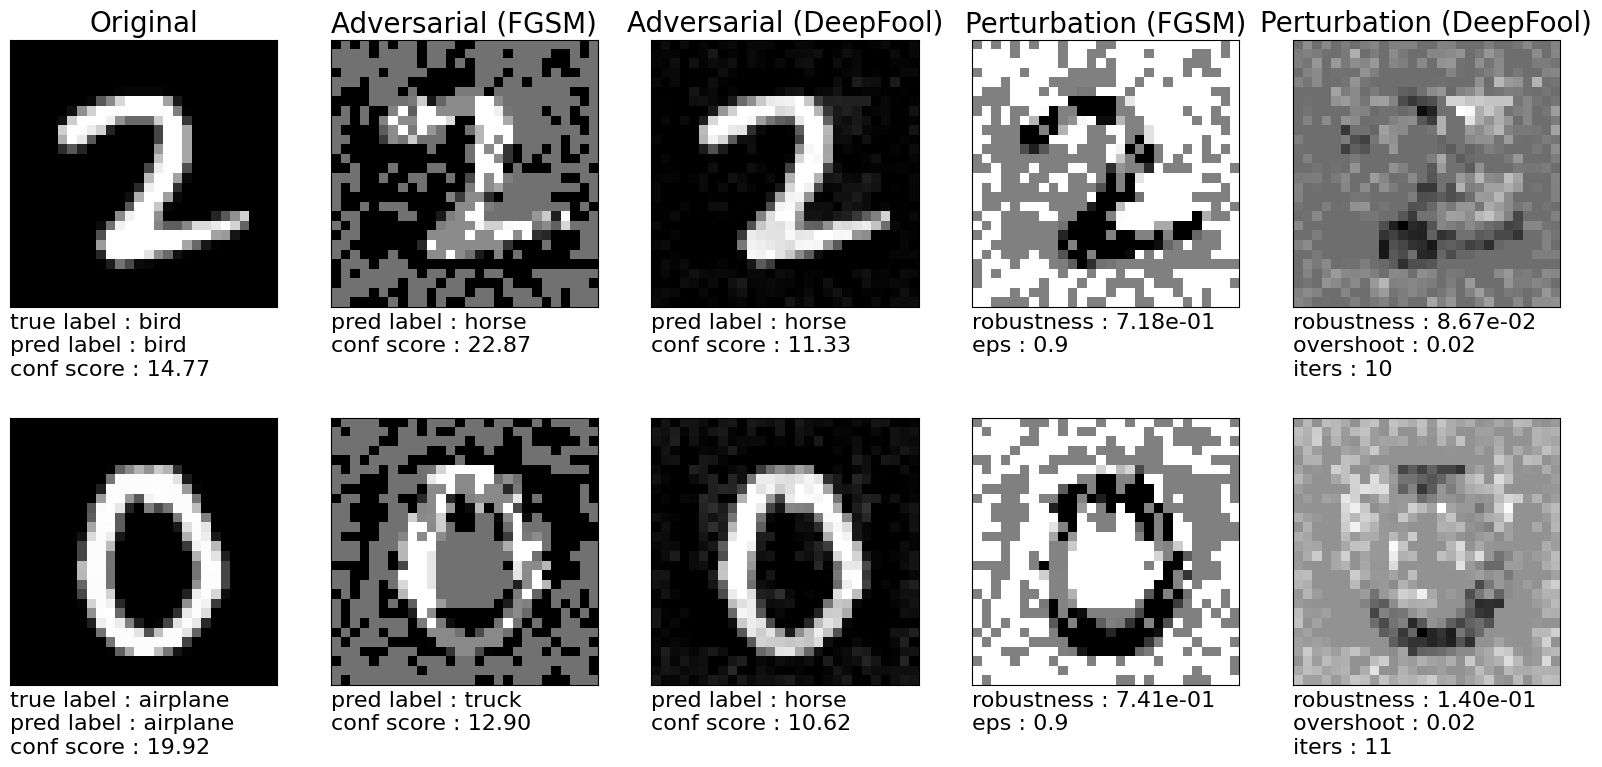



Отображение изображений для epsilon: 10


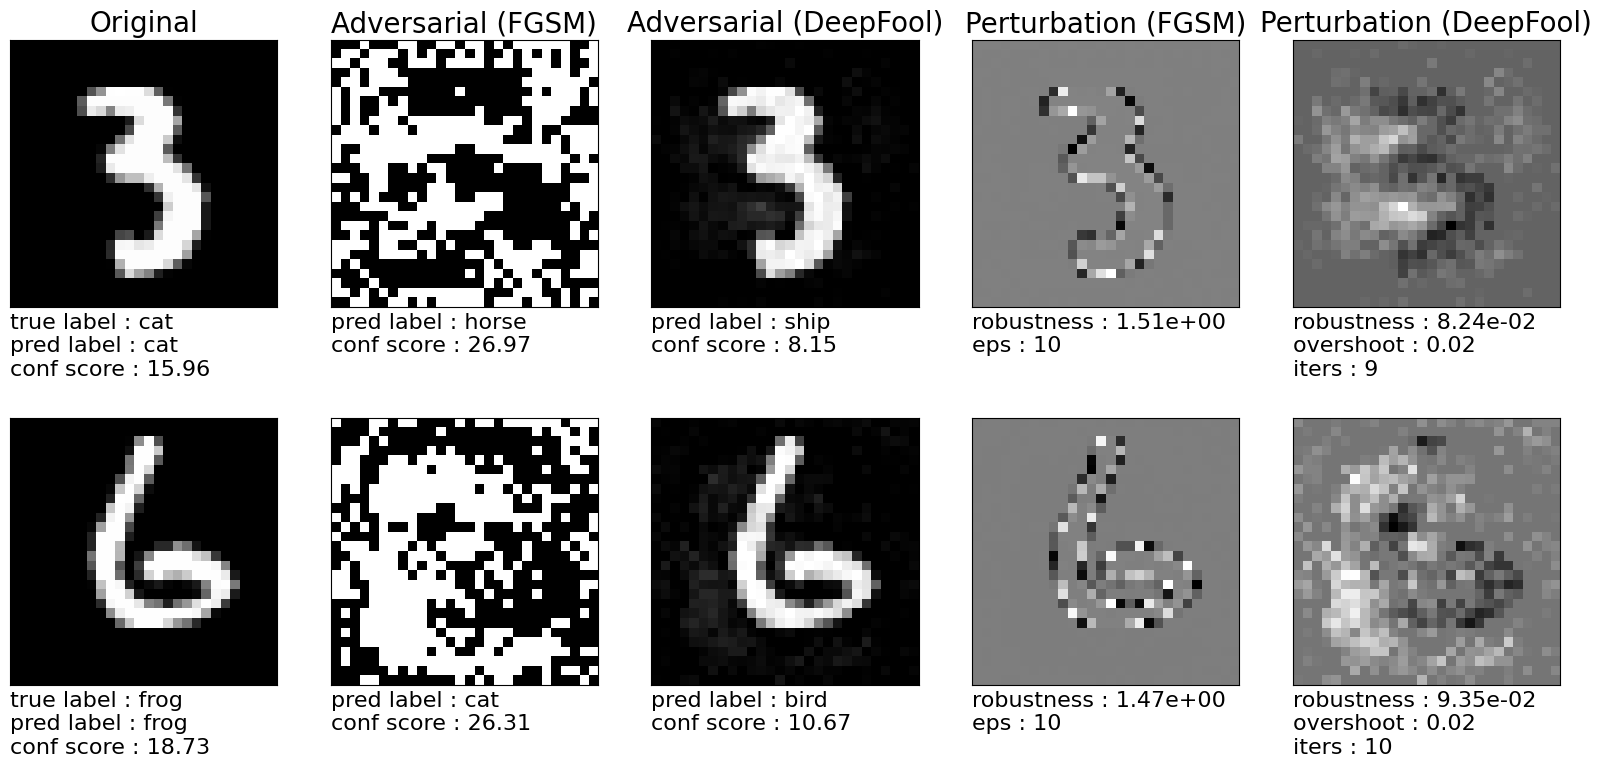

In [23]:
model = FC_500_150().to(device)
for fgsm_eps in fgsm_eps_mass:
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
  print('')
  print('')
  print(f"Отображение изображений для epsilon: {fgsm_eps}")

  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)

  if device.type == 'cuda':
      torch.cuda.empty_cache()

**Аналогично двум прошлым моделям значения параметра *eps* <= 0.02 почти не несут никаких искажений и незначительно ухудшают работу нейросети, а >= 0.5 уже заметно изменяет изображение и коордмнально ухудшают работу**

### **15.5 Анализируем различные значения переменной *eps* и сравниваем ошибки нейронной сети (модель - LeNet , датасет - MNIST):**


In [24]:
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
for fgsm_eps in fgsm_eps_mass:
  print('')
  print('')
  print('fgsm eps = ', fgsm_eps)
  filename = 'mnist_lenet_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(filename, 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
  if device.type == 'cuda':
      torch.cuda.empty_cache()



fgsm eps =  0.001


<ipython-input-24-925e00cbcba6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.10

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 1.69%
FGSM Robustness : 8.06e-04
FGSM Time (All Images) : 1.46 s
FGSM Time (Per Image) : 145.81 us


fgsm eps =  0.02


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 2.56%
FGSM Robustness : 1.59e-02
FGSM Time (All Images) : 0.90 s
FGSM Time (Per Image) : 90.45 us


fgsm eps =  0.5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 82.92%
FGSM Robustness : 3.83e-01
FGSM Time (All Images) : 0.89 s
FGSM Time (Per Image) : 89.19 us


fgsm eps =  0.9


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 93.80%
FGSM Robustness : 6.81e-01
FGSM Time (All Images) : 0.87 s
FGSM Time (Per Image) : 87.17 us


fgsm eps =  10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 94.15%
FGSM Robustness : 1.46e+00
FGSM Time (All Images) : 0.99 s
FGSM Time (Per Image) : 98.83 us


**До значения параметра *eps* равного 0.02 ошибка FGSM растет плавно и очень медленно (от 1% до 3%), но при значении = 0.5 она резко возрастает до 82%  и при значниях > 0.5 ошибка продолжает увеличиваться (при *eps* = 0.9 ошибка равна 94%)**

#### **15.5.1 Визуализируем как значение переменной *eps* влияет на входные изображения при атаке:**



Отображение изображений для epsilon: 0.001


<ipython-input-25-40e3033c4b5a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.10

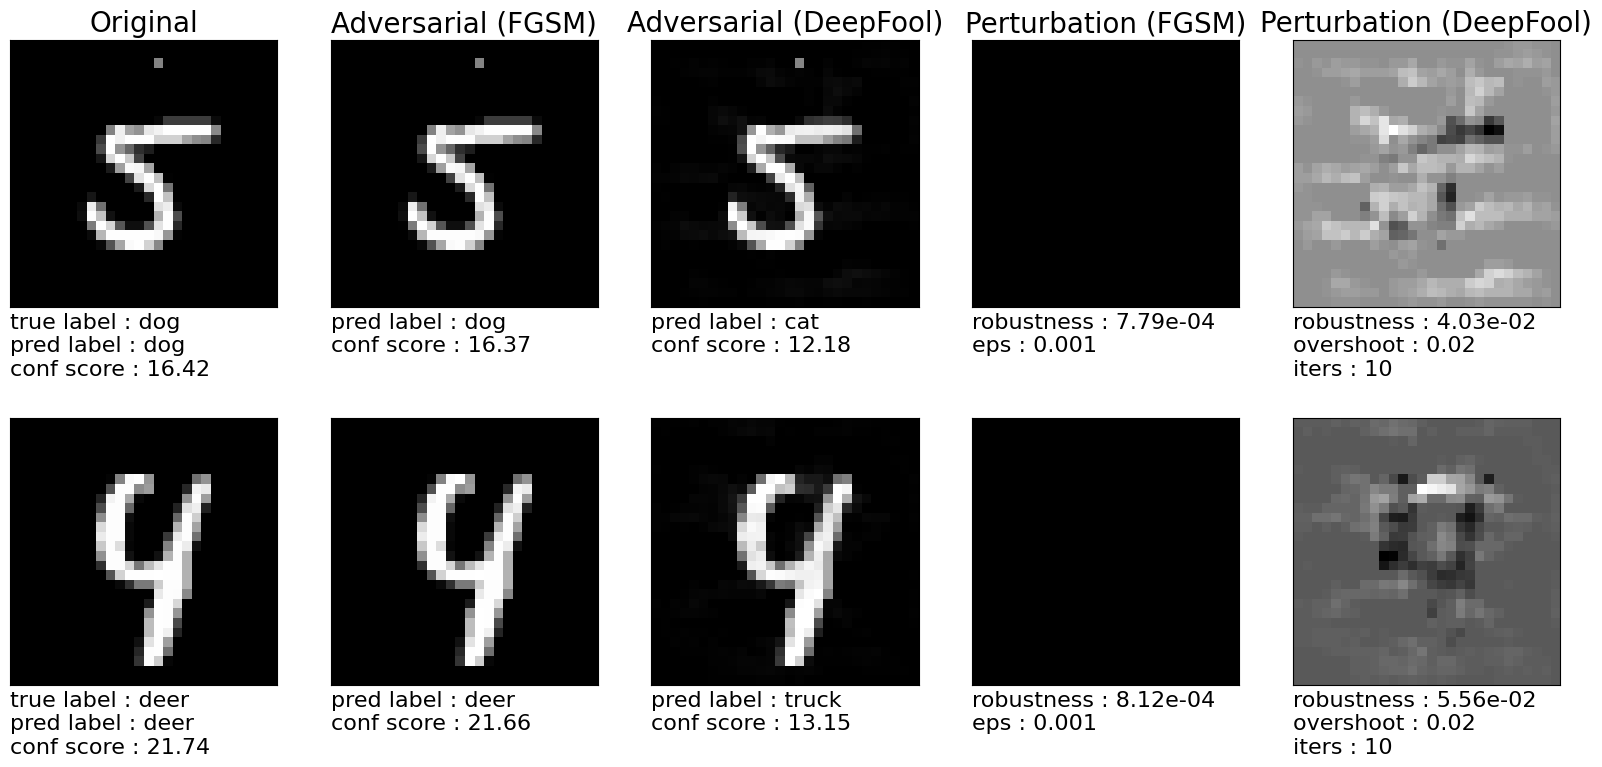



Отображение изображений для epsilon: 0.02


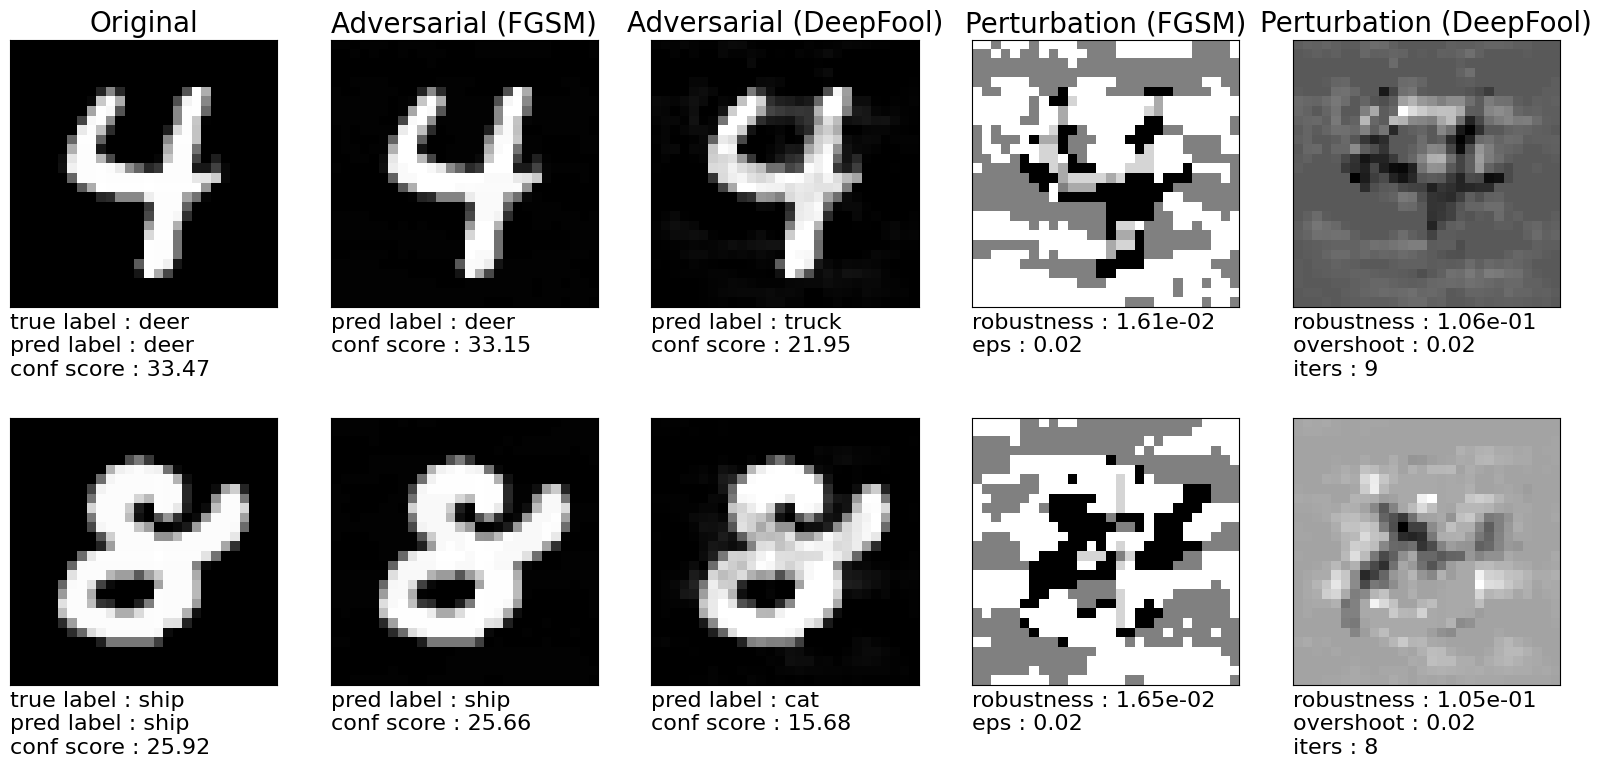



Отображение изображений для epsilon: 0.5


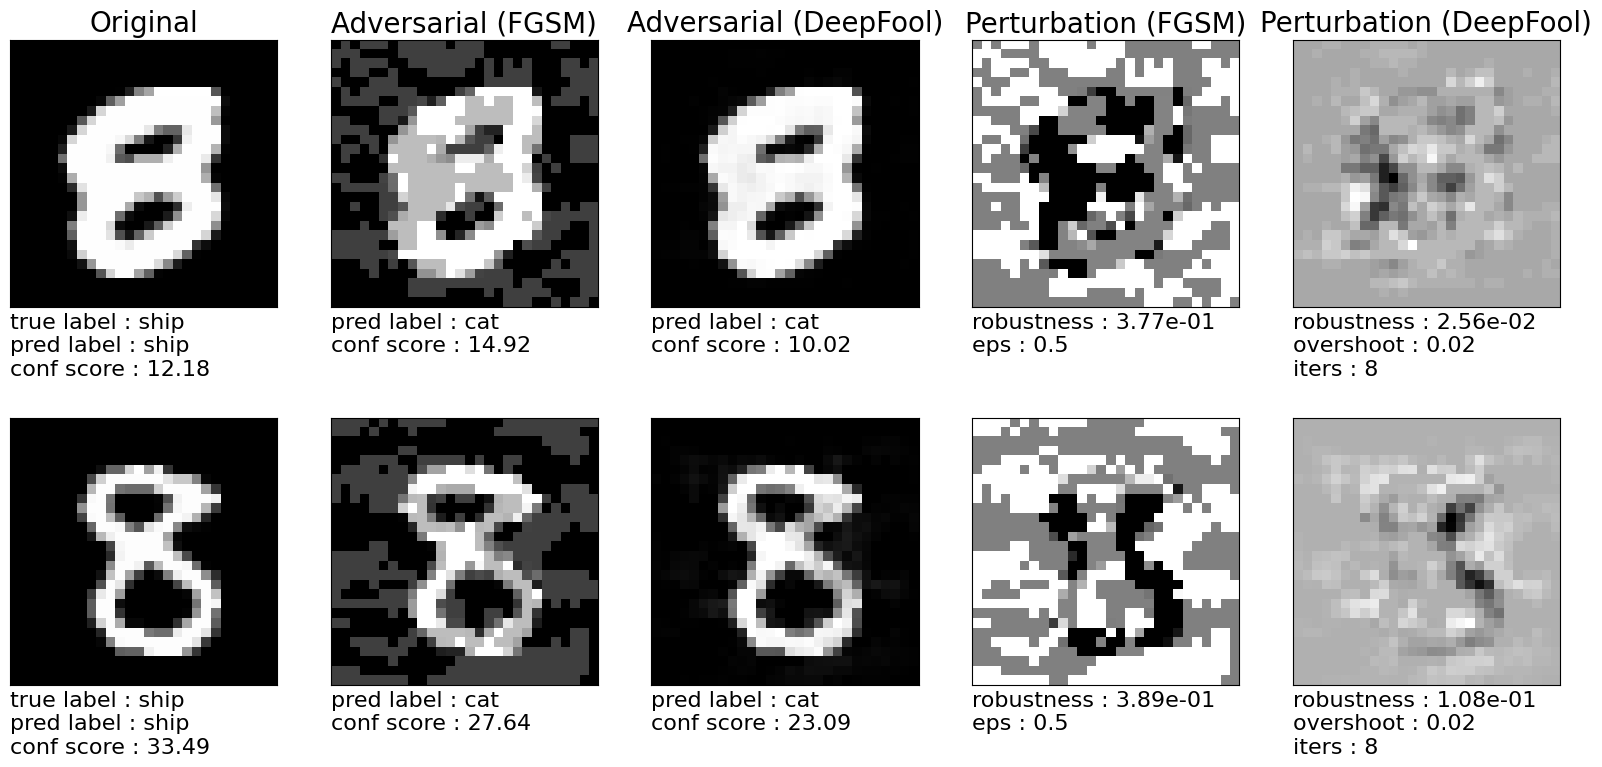



Отображение изображений для epsilon: 0.9


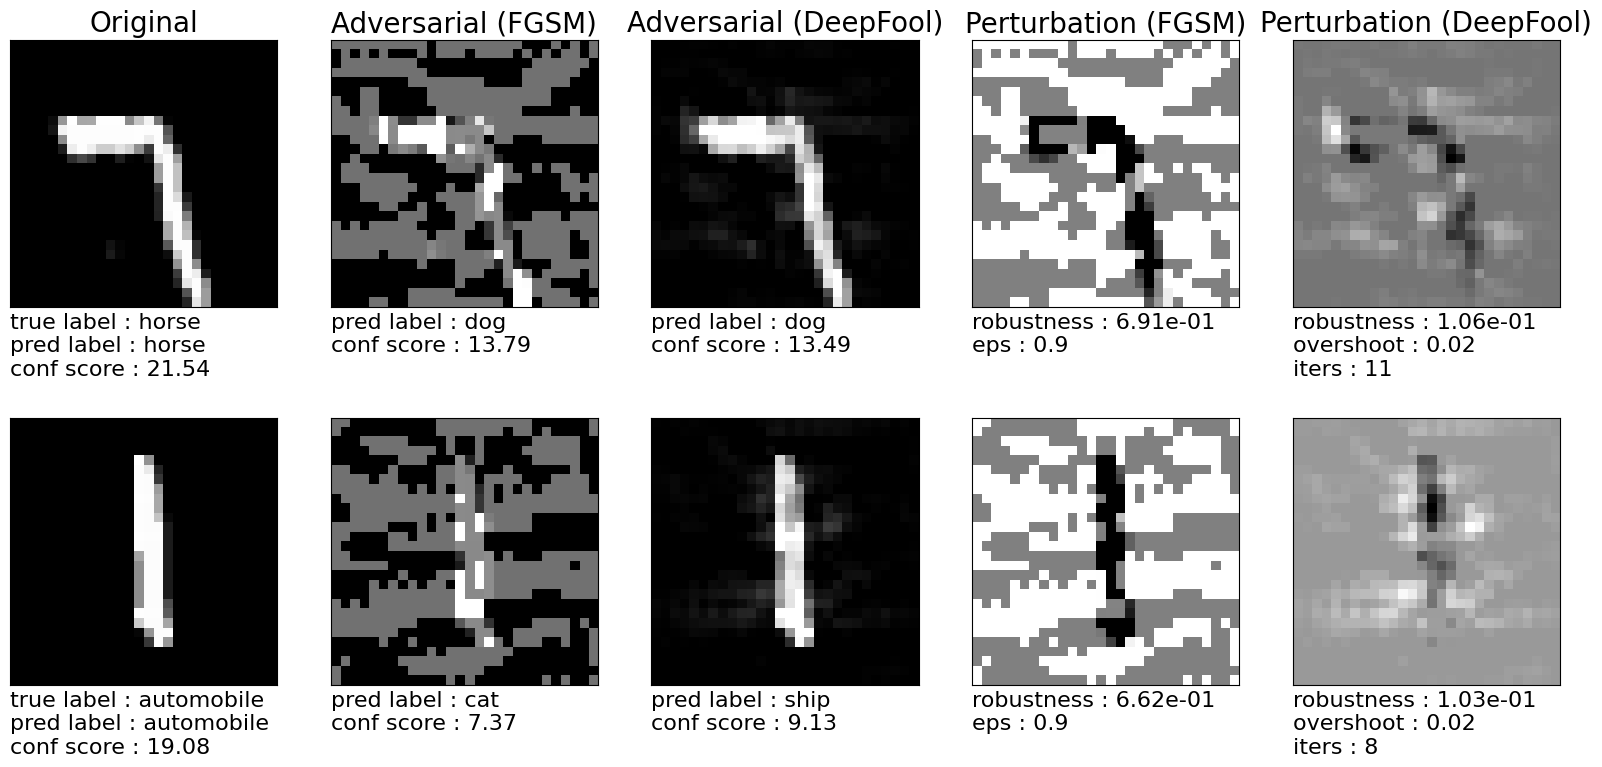



Отображение изображений для epsilon: 10


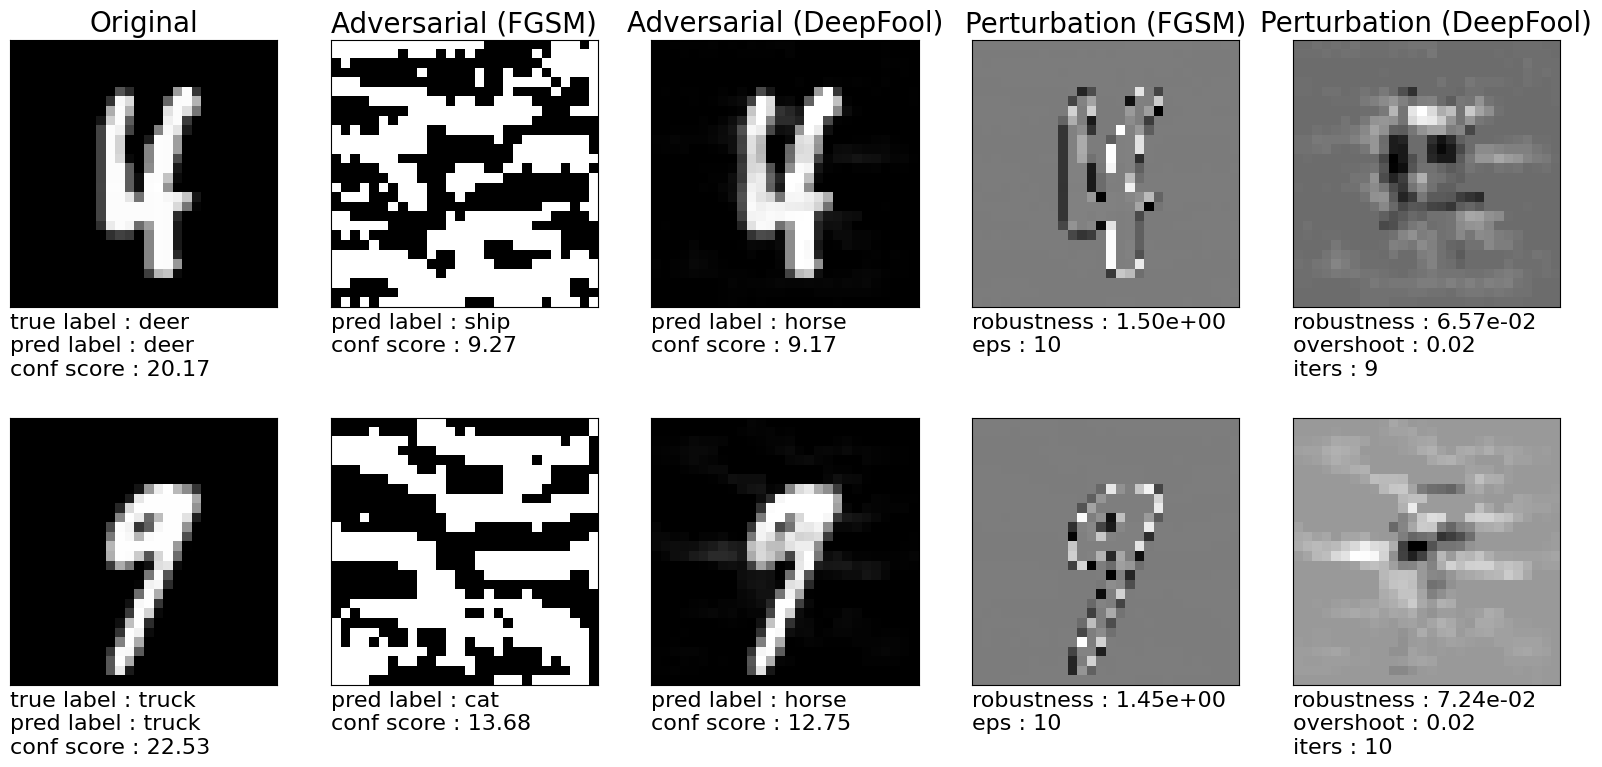

In [25]:
model = LeNet_MNIST().to(device)
for fgsm_eps in fgsm_eps_mass:
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
  print('')
  print('')
  print(f"Отображение изображений для epsilon: {fgsm_eps}")

  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=20, fig_height=9, label_map=cifar_classes)

  if device.type == 'cuda':
      torch.cuda.empty_cache()

**Аналогично всем прошлым моделям значения параметра *eps* <= 0.02 почти не несут никаких искажений и незначительно ухудшают работу нейросети, а >= 0.5 уже заметно изменяет изображение и коордмнально ухудшают работу**

### **Вывод:**
Таким образом, при увеличении значений eps увеличиваются искажения на исходных изображениях и снижается точность нейронной сети. Для успешной атаки значение eps не должно быть большим, иначе её слишком легко обнаружить из-за координальных искажений исходных изображений.

Самая уязвимая для атак нейросеть из рассмотренных – FC на датасете MNIST, так как у этой нейросети больше остальных росла ошибка при атаке. Это свидетельствует о том, что архитектура сети и особенности обучающего набора данных играют ключевую роль в её устойчивости к атакам.

Кроме того, все нейронные сети, рассмотренные в лабораторной работе, уязвимы к атакам при подборе параметров. При точечном подборе точность работы нейронных сетей можно уменьшить на 80% и более. Это подчеркивает важность разработки методов защиты и повышения устойчивости моделей к подобным атакам.
